# Iterations on preprocessing

Let's restart from scratch on lowercased questions.

Note we will loose some information by lowercasing everything...


In [1]:
# Ugly incantation to make our 'framework' working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='preprocessing'
# Do a bit of checks before actually running long code
UNITARY_TEST = True
print_alert('You will use environment %s' % EXPERIMENT)

prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))

## Challenge and training are not equivalent

% of duplicate in training is not the same in challenge !
We don't have the challenge's answer but by scoring a constant prediction and using logloss definition, we can guess the distribution of duplicates in challenge

It's 17.46 %

To fix that we can:

* duplicate some negative cases in training to match challenge distribution
* use weights : each case has a weight !=1 and all algorithms are supposed to be able to deal with that info
I choose to use weights (less memory needed ?)

In [2]:

CHALLENGE_DUPLICATE_PERCENT = 0.1746

#return the weight for 0 and weight for 1 needed to rebalance dataframe like challenge
def balanced_weights(dataframe,expected_positive_ratio):
    current_positive_ratio = dataframe['is_duplicate'].sum()/len(dataframe)
    weight_for_negative = (1-expected_positive_ratio)/(1-current_positive_ratio)
    weight_for_positive = expected_positive_ratio/current_positive_ratio
    return weight_for_positive,weight_for_negative

print_warning('OUPS !! %% of duplicates in train is %.3f. In challenge it is %.3f %%' % (train_dataframe['is_duplicate'].sum()/len(train_dataframe),CHALLENGE_DUPLICATE_PERCENT))

# create a new 'weight' column to training dataset
# Do not forget to remove this column from features !!!
print_warning("let's add some weights to rebalance the data")
weight_for_1,weight_for_0 = balanced_weights(train_dataframe,CHALLENGE_DUPLICATE_PERCENT)
print_info('Weight for positive case %.3f' % weight_for_1)
print_info('Weight for negative case %.3f' % weight_for_0)
train_dataframe['weight'] = train_dataframe['is_duplicate'].map( {0:weight_for_0, 1:weight_for_1})

assert int(train_dataframe['weight'].sum()/len(train_dataframe)) == 1, "training dataset has not been properly rebalanced"
print_info("Training data set has been properly rebalanced")
print_info('Weights distribution:')
train_dataframe['weight'].describe()

count    404290.000000
mean          1.000000
std           0.403239
min           0.472917
25%           0.472917
50%           1.308493
75%           1.308493
max           1.308493
Name: weight, dtype: float64

### Step 1: Lower case everything

In [3]:
# our main tool to add feature
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]
    
def build_all_lower_data(dataframe):
    print_info('Lower case question1')
    dataframe['question1'] = dataframe['question1'].str.lower()
    print_info('Lower case question2')
    dataframe['question2'] = dataframe['question2'].str.lower()
    return dataframe

train_dataframe = load_or_build_dataframe('Lower case everything in training','training_lower',build_all_lower_data,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Lower case everything in challenge','challenge_lower',build_all_lower_data,challenge_dataframe)

### Step 2 : build our basic features
* Nb words in question 1
* Nb words in question 2
* Nb common words
* Nb common words/nb words in question 1
* Nb common words/nb words in question 2
* Nb non common words in question 1
* Nb non common words in question 2
* Nb common words/(Nb words in question1 + Nb words in question2)

Note this is done on raw question content : no preprocessing

In [4]:
def build_basic_features_one_row(q1,q2):
    q1 = set(q1.split())
    len_q1 = len(q1)
    q2 = set(q2.split())
    len_q2 = len(q2)

    common = q1&q2
    len_common = len(common)

    uncommon_q1 = q1-common
    len_uncommon_q1 = len(uncommon_q1)

    uncommon_q2 = q2-common
    len_uncommon_q2 = len(uncommon_q2)
    #       0     1           2            3         4               5               6      7      8                        9                        10
    return common,uncommon_q1,uncommon_q2,len_common,len_uncommon_q1,len_uncommon_q2,len_q1,len_q2,len_common/max(1,len_q1),len_common/max(1,len_q2),len_common/(len_q1+len_q2)
    
def build_all_basic_features(dataframe):
    print_warning('Compute all features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: build_basic_features_one_row(r.question1,r.question2))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'nb_words_question2','temp',lambda x: x[7])

    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'nb_common_words/nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'nb_common_words/nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'nb_words_question1-common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'nb_words_question2-common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe


train_dataframe = load_or_build_dataframe('Training data + basic features','training_basic_features',build_all_basic_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge data + basic features','challenge_basic_features',build_all_basic_features,challenge_dataframe)

Let's take a look in our new data

In [5]:
train_dataframe.head(2).transpose()

0  \
id                                                                                                                        0   
qid1                                                                                                                      1   
qid2                                                                                                                      2   
question1                                                what is the step by step guide to invest in share market in india?   
question2                                                         what is the step by step guide to invest in share market?   
is_duplicate                                                                                                              0   
weight                                                                                                              1.30849   
nb_words_question1                                                                                                       12   
nb_words_question2                                                                                                       11   
nb_common_words                                                                                                          10   
nb_common_words/nb_words_question1                                                                                 0.833333   
nb_common_words/nb_words_question2                                                                                 0.909091   
nb_words_question1-common_words                                                                                           2   
nb_words_question2-common_words                                                                                           1   
nb_common_words/(nb_words_question1+nb_words_question2)                                                            0.434783   
common_words                                                        {invest, share, in, to, is, by, the, what, step, guide}   
uncommon_words_question1                                                                                   {india?, market}   
uncommon_words_question2                                                                                          {market?}   

                                                                                                                                                1  
id                                                                                                                                              1  
qid1                                                                                                                                            3  
qid2                                                                                                                                            4  
question1                                                                                     what is the story of kohinoor (koh-i-noor) diamond?  
question2                                                what would happen if the indian government stole the kohinoor (koh-i-noor) diamond back?  
is_duplicate                                                                                                                                    0  
weight                                                                                                                                    1.30849  
nb_words_question1                                                                                                                              8  
nb_words_question2                                                                                                                             12  
nb_common_words                                                                                                                                 4  
nb_common_words/nb_words_question1                                              

Let's take a look in common words & uncommon_words_question1

In [6]:
train_dataframe[['common_words','uncommon_words_question1']]

common_words  \
0                                   {invest, share, in, to, is, by, the, what, step, guide}   
1                                                       {what, kohinoor, (koh-i-noor), the}   
2                                                               {speed, internet, can, how}   
3                                                                                        {}   
4                                                                               {in, which}   
...                                                                                     ...   
404285  {version?, in, many, latest, how, the, programming, are, keywords, there, language}   
404286                                                     {after, is, life, death?, there}   
404287                                                                              {coin?}   
404288                                                                                 {of}   
404289                                       {with, to, is, cousin?, sex, have, like, what}   

                                                                                            uncommon_words_question1  
0                                                                                                   {india?, market}  
1                                                                                          {diamond?, is, story, of}  
2                                                      {my, increase, a, connection, the, vpn?, i, while, using, of}  
3                                                        {solve, mentally, lonely?, am, how, very, can, it?, why, i}  
4                                    {water, and, dissolve, methane, carbon, salt,, one, quikly, sugar,, di, oxide?}  
...                                                                                                              ...  
404285                                                                                                  {racket, of}  
404286                                                                                            {do, you, believe}  
404287                                                                                               {what, is, one}  
404288  {indian, approx, is, living, for, student?, uic, while, in, cost, chicago,, an, the, studying, annual, what}  
404289                                                                                                            {}  

[404290 rows x 2 columns]

OK common words and uncommon words are polluted by tons of words like: is,with,to,..  

These are stop words.

### Step 3 : remove a first set of stop words
We start with stopwords coming from nltk

In [7]:
from nltk.corpus import stopwords

def build_no_stopwords_features_one_row(q1,q2,stopwords):
    q1 = set([w for w in q1.split() if w not in stopwords])
    len_q1 = len(q1)
    q2 = set([w for w in q2.split() if w not in stopwords])
    len_q2 = len(q2)

    common = q1&q2
    len_common = len(common)

    uncommon_q1 = q1-common
    len_uncommon_q1 = len(uncommon_q1)

    uncommon_q2 = q2-common
    len_uncommon_q2 = len(uncommon_q2)
    #       0     1           2            2         4               5               6      7      8                        9                        10
    return common,uncommon_q1,uncommon_q2,len_common,len_uncommon_q1,len_uncommon_q2,len_q1,len_q2,len_common/max(1,len_q1),len_common/max(1,len_q2),len_common/max(1,(len_q1+len_q2))
    

def build_nltk_stop_words_features(dataframe):
    print_warning('Remove stopwords from question 1 & question2')
    
    print_warning('Compute all nltk features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: build_no_stopwords_features_one_row(r.question1,r.question2,nltk_stopwords))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'nltk_nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'nltk_nb_words_question2','temp',lambda x: x[7])

    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'nltk_nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'nltk_nb_common_words/nltk_nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'nltk_nb_common_words/nltk_nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'nltk_nb_words_question1-nltk_common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'nltk_nb_words_question2-nltk_common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'nltk_common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'nltk_uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'nltk_uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe

nltk_stopwords = set(stopwords.words('english'))
print_info( 'There is %d stopwords in nltk' % len(nltk_stopwords))

train_dataframe = load_or_build_dataframe('Training: Build features aware of nltk stopwords','training_nltk_stop_words_features',build_nltk_stop_words_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge: Build features aware of nltk stopwords','challenge_nltk_stop_words_features',build_nltk_stop_words_features,challenge_dataframe)

Did we change anything ?

In [8]:
nb_changed_train = int(numpy.where(train_dataframe['nltk_nb_common_words']!=train_dataframe['nb_common_words'],1,0).sum())
print_info('We have changed %.2f %% of nb common_words in training!!' % (nb_changed_train*100./len(train_dataframe)))
nb_changed_challenge = int(numpy.where(challenge_dataframe['nltk_nb_common_words']!=challenge_dataframe['nb_common_words'],1,0).sum())
print_info('We have changed %.2f %% of nb common_words in challenge !!' % (nb_changed_challenge*100./len(challenge_dataframe)))
train_dataframe[['common_words','nltk_common_words','uncommon_words_question1','nltk_uncommon_words_question1']].head(2)

common_words             nltk_common_words   uncommon_words_question1 nltk_uncommon_words_question1
0  {invest, share, in, to, is, by, the, what, step, guide}  {invest, step, share, guide}           {india?, market}              {india?, market}
1                      {what, kohinoor, (koh-i-noor), the}      {kohinoor, (koh-i-noor)}  {diamond?, is, story, of}             {diamond?, story}

Step 4: remove more stopwords coming from sklearn


In [9]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

sk_stopwords = set(ENGLISH_STOP_WORDS)
print_info('There is %d words in nltk stop words' % len(nltk_stopwords))
print_info('There is %d words in sklearn stop words' % len(sk_stopwords))
new_stopwords = [w for w in sk_stopwords if w not in nltk_stopwords]
print_info('There is %d new stop words in sklearn stop words' % len(new_stopwords))

all_stop_words = nltk_stopwords | sk_stopwords
print_info('There is %d words in the union of stop words' % len(all_stop_words))

def build_all_stop_words_features(dataframe): 
    print_warning('Compute all features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: build_no_stopwords_features_one_row(r.question1,r.question2,all_stop_words))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'all_nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'all_nb_words_question2','temp',lambda x: x[7])

  
    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'all_nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'all_nb_common_words/all_nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'all_nb_common_words/all_nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'all_nb_words_question1-all_common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'all_nb_words_question2-all_common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'all_common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'all_uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'all_uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe


train_dataframe = load_or_build_dataframe('Training: Build features aware of all stopwords','training_all_stop_words_features',build_all_stop_words_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge: Build features aware of all stopwords','challenge_all_stop_words_features',build_all_stop_words_features,challenge_dataframe)

Try to recap the changes we made

In [10]:
nb_changed_train = int(numpy.where(train_dataframe['nltk_nb_common_words'] != train_dataframe['nb_common_words'],1,0).sum())
print_info('With nltk stop words we have changed %.2f %% of nb common_words in training!!' % (nb_changed_train*100./len(train_dataframe)))
nb_changed_train = int(numpy.where(train_dataframe['all_nb_common_words'] != train_dataframe['nb_common_words'],1,0).sum())
print_warning('Removing also sklearn stop words we have changed %.2f %% of nb common_words in training!!' % (nb_changed_train*100./len(train_dataframe)))

nb_changed_challenge = int(numpy.where(challenge_dataframe['nltk_nb_common_words']!=challenge_dataframe['nb_common_words'],1,0).sum())
print_info('With nltk stop words We have changed %.2f %% of nb common_words in challenge !!' % (nb_changed_challenge*100./len(challenge_dataframe)))
nb_changed_challenge = int(numpy.where(challenge_dataframe['all_nb_common_words']!=challenge_dataframe['nb_common_words'],1,0).sum())
print_warning('Removing also sklearn stop words we have changed %.2f %% of nb common_words in challenge !!' % (nb_changed_challenge*100./len(challenge_dataframe)))

changed = train_dataframe[train_dataframe['nltk_nb_common_words']!=train_dataframe['all_nb_common_words']]
changed[['common_words','nltk_common_words','all_common_words','uncommon_words_question1','nltk_uncommon_words_question1','all_uncommon_words_question1']].head(3)

common_words                nltk_common_words          all_common_words uncommon_words_question1 nltk_uncommon_words_question1  \
13                                   {your, sexual, first, was, what}                  {sexual, first}                  {sexual}      {experience, like?}           {experience, like?}   
30                             {do, you, what's, one, better?, thing}    {better?, thing, what's, one}  {better?, thing, what's}        {like, would, to}                 {would, like}   
32  {to, thrones, you, be, villain, game, would, the, what, most, of}  {game, would, thrones, villain}  {game, thrones, villain}   {likely, mercy?, give}        {likely, mercy?, give}   

   all_uncommon_words_question1  
13          {experience, like?}  
30                       {like}  
32             {likely, mercy?}

We have tons of useless and costly data in memory. Let's get rid of it

In [11]:
train_dataframe=train_dataframe.drop(columns=['common_words','uncommon_words_question1','uncommon_words_question2','nltk_common_words','nltk_uncommon_words_question1','nltk_uncommon_words_question2','all_common_words','all_uncommon_words_question1','all_uncommon_words_question2'])
challenge_dataframe=challenge_dataframe.drop(columns=['common_words','uncommon_words_question1','uncommon_words_question2','nltk_common_words','nltk_uncommon_words_question1','nltk_uncommon_words_question2','all_common_words','all_uncommon_words_question1','all_uncommon_words_question2'])

## Clean questions

Questions are polluted by many small issues tha impact also the quality of our share/unshared words:
* typos : initilly for initially
* units: 100,000rs for 100000 roupies
* punctaion : each question ends with a ? glued to last word
* ...

Notebook find_preprocessing allowed us to defaint around 50 cleaning rules we are apply here


In [12]:
# here is the code to preprocess questions
import re

# I do special stuff with $ and roupie char
FINAL_PUNC_CLEANER = str.maketrans(dict([ (c,' ') for c in '!"#%&\'()*+,./:;<=>?[\\]^_`{|}~-@']))

def clean_string(str):
    str = re.sub('\?',' ',str) # ?
    # odd chars
    # will generate more ' so do it first
    str = re.sub("’", "'", str) # special single quote
    str = re.sub("`", "'", str) # special single quote
    str = re.sub("“", '"', str) # special double quote
    str = re.sub("？", "?", str) 
    str = re.sub("…", " ", str) 
    str = re.sub("é", "e", str)
    
    # shortcuts
    str = re.sub('\'s', ' is', str) 
    str = re.sub(' whats ', ' what is ', str)
    str = re.sub('\'ve', ' have ', str)
    str = re.sub("can't", 'can not', str)
    # this one is tricky do it in order
    str = re.sub("wouldn't", 'would not', str)
    str = re.sub("n't", ' not ', str)
    str = re.sub("i'm", 'i am', str)
    str = re.sub('\'re', ' are ', str)
    str = re.sub('\'d', ' would ', str)
    str = re.sub('\'ll', ' will ', str)
    str = re.sub('e\.g\.', ' eg ', str)
    str = re.sub('b\.g\.', ' bg ', str)
    str = re.sub('e-mail', ' email ', str)
    str = re.sub('\(s\)', ' ', str)

    # Numbers and measures are a true mess
    # 12,000 -> 12000
    str = re.sub('(?<=[0-9])\,(?=[0-9])', '', str)

    # Quora is very used in India so roupie (rs) is often present
    str = re.sub("(?<=[0-9])rs ", " rs ", str)
    str = re.sub(" rs(?=[0-9])", " rs ", str)

    # stolen at kaggle : https://www.kaggle.com/currie32/the-importance-of-cleaning-str

#    str = re.sub('[c-fC-F]\:\/', ' disk ', str)
#    str = re.sub('(\d+)(kK)', ' \g<1>000 ', str)
    # very weird !!! these ones decrease the hit % WTF ?

    #str = re.sub(r" (the[\s]+|the[\s]+)?us(a)? ", " usa ", str)
    #str = re.sub('(the[\s]+|the[\s]+)?united state(s)?', ' usa ', str)

    str = re.sub(r" uk ", " england ", str)
    str = re.sub(r" imrovement ", " improvement ", str)
    str = re.sub(r" intially ", " initially ", str)
    str = re.sub(r" dms ", " direct messages ", str)  
    str = re.sub(r" demonitization ", " demonetization ", str) 
    str = re.sub(r" actived ", " active ", str)
    str = re.sub(r" kms ", " kilometers ", str)
    str = re.sub(r" cs ", " computer science ", str) 
    str = re.sub(r" upvote", " up vote", str)
    str = re.sub(r" iphone ", " phone ", str)
    str = re.sub(r" \0rs ", " rs ", str)
    str = re.sub(r" calender ", " calendar ", str)
    str = re.sub(r" ios ", " operating system ", str)
    str = re.sub(r" programing ", " programming ", str)
    str = re.sub(r" bestfriend ", " best friend ", str)
    str = re.sub(r" iii ", " 3 ", str)
    str = re.sub(r" banglore ", " bangalore ", str)
    str = re.sub(r" j k ", " jk ", str)
    str = re.sub(r" J\.K\. ", " jk ", str)

    
    # some others
    str = re.sub(r"60k", " 60000 ", str)
    str = re.sub(r" e g ", " eg ", str)
    str = re.sub(r" b g ", " bg ", str)
    str = re.sub(r"\0s", "0", str)
    str = re.sub(r" 9 11 ", "911", str)
    str = re.sub(r"\s{2,}", " ", str)
    str = re.sub(r" usa ", " America ", str)
    str = re.sub(r" u s ", " America ", str)
    str = re.sub(r"'m ", " am ", str)

    # units
    str = re.sub(r"(\d+)kgs ", lambda m: m.group(1) + ' kg ', str)        # e.g. 4kgs => 4 kg
    str = re.sub(r"(\d+)kg ", lambda m: m.group(1) + ' kg ', str)         # e.g. 4kg => 4 kg
    str = re.sub(r"(\d+)k ", lambda m: m.group(1) + '000 ', str)          # e.g. 4k => 4000
    str = re.sub(r"\$(\d+)", lambda m: m.group(1) + ' dollar ', str)
    str = re.sub(r"(\d+)\$", lambda m: m.group(1) + ' dollar ', str)
    # This one is important in 2017
    str = re.sub(' donald trump',' trump ',str)
    str = re.sub(' dollars',' dollar ',str)
    str = re.sub(' quaro',' quora ',str)
    str = re.sub(r"googling", " google ", str)
    str = re.sub(r"googled", " google ", str)
    str = re.sub(r"googleable", " google ", str)
    str = re.sub(r"googles", " google ", str)
    
    str = re.sub(r"₹", " rs ", str)      # 测试！
    str = re.sub(r"\$", " dollar ", str)  
    
    #str = re.sub('[^\x00-\x7F]+', ' ', str)
    # this will blank any of !"#%&\'()*+,./:;<=>?[\\]^_`{|}~-@
    # Note the @ is dubious : won't we loose some emails ??
    # and $ is replaced by dollar before
    str = str.translate(FINAL_PUNC_CLEANER)

    return str

In [13]:
def clean_build_no_stopwords_features_one_row(q1,q2,stopwords):
    q1 = clean_string(q1)
    q2 = clean_string(q2)
    q1 = set([w for w in q1.split() if w not in stopwords])
    len_q1 = len(q1)
    q2 = set([w for w in q2.split() if w not in stopwords])
    len_q2 = len(q2)

    common = q1&q2
    len_common = len(common)

    uncommon_q1 = q1-common
    len_uncommon_q1 = len(uncommon_q1)

    uncommon_q2 = q2-common
    len_uncommon_q2 = len(uncommon_q2)
    #       0     1           2            2         4               5               6      7      8                        9                        10
    return common,uncommon_q1,uncommon_q2,len_common,len_uncommon_q1,len_uncommon_q2,len_q1,len_q2,len_common/max(1,len_q1),len_common/max(1,len_q2),len_common/max(1,(len_q1+len_q2))


def clean_build_all_stop_words_features(dataframe): 
    print_warning('Clean text and compute all features in one shot')
    add_column_from_columns(dataframe,'temp',lambda r: clean_build_no_stopwords_features_one_row(r.question1,r.question2,all_stop_words))
    
    print_warning('Extract nb_words_question1')
    add_column_from_column(dataframe,'clean_all_nb_words_question1','temp',lambda x: x[6])
    print_warning('Extract nb_words_question2')
    add_column_from_column(dataframe,'clean_all_nb_words_question2','temp',lambda x: x[7])

  
    print_warning('Extract Nb common_words between question1 & question2')
    add_column_from_column(dataframe,'clean_all_nb_common_words','temp',lambda x: x[3])

    print_warning('Extract Nb common words/nb words in question1')
    add_column_from_column(dataframe,'clean_all_nb_common_words/clean_all_nb_words_question1','temp',lambda x: x[8])

    print_warning('Extract Nb common words/nb words in question2')
    add_column_from_column(dataframe,'clean_all_nb_common_words/clean_all_nb_words_question2','temp',lambda x: x[9])

    print_warning('Extract Nb words in question1 not in common words')
    add_column_from_column(dataframe,'clean_all_nb_words_question1-clean_all_common_words','temp',lambda x: x[4])

    print_warning('Extract Nb words in question2 not in common words')
    add_column_from_column(dataframe,'clean_all_nb_words_question2-clean_all_common_words','temp',lambda x: x[5])

    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_column(dataframe,'clean_all_nb_common_words/(clean_all_nb_words_question1+clean_all_nb_words_question2)','temp',lambda x: x[10])
    
    print_warning('Extract common words between question1 & question2')
    add_column_from_column(dataframe,'clean_all_common_words','temp',lambda x: x[0])
    
    print_warning('Extract uncommon words in question1')
    add_column_from_column(dataframe,'clean_all_uncommon_words_question1','temp',lambda x: x[1])

    print_warning('Extract uncommon words in question2')
    add_column_from_column(dataframe,'clean_all_uncommon_words_question2','temp',lambda x: x[2])
    dataframe = dataframe.drop (columns='temp')  
    return dataframe

train_dataframe = load_or_build_dataframe('Training data + clean + all stop words features','training_clean_all_stop_words_features',clean_build_all_stop_words_features,train_dataframe)
challenge_dataframe = load_or_build_dataframe('Challenge data + clean + all stop words features','challenge_clean_all_stop_words_features',clean_build_all_stop_words_features,challenge_dataframe)

### Lemmatized questions

Lemmatization allows to retrieve the root word (the lemme) of any word : trainings->train, will->be,...
This another way to cleanup lists of shared/unshared words.

Lemmatisation has been done in notebod spacy_preprocessing and is quite heavy.
We just get back the results of this notebook in cache and glue them to our datasets

### Entities
Named entities are high level entities like a person, a place, an organisation,... detected in a text. Spacy can detect such objects (quit heavy operation). 
We detect these entities for each questions and see if there are some common ones. Idea is if questions talk about the same things with the same words, there are better chances they are duplicated. 
We have computed all these numbers (and ratios to get rid of scale issues with long questions) in the notebook spacy_preprocessing and just glue the results to our datasets

In [14]:
def glue_lemmes_entities_newsgroups_similarities(dataframe,dataset_name):
    print_warning(dataset_name)
    lemmatized_entities = load_global_dataframe(dataset_name+'_final_lemmatized_entities_features')
   # ugly but easy : I prefer this order of fields
    lemmatized_entities = lemmatized_entities.reindex(
        columns=[
        'lemmatized_nb_words_question1',
        'lemmatized_nb_words_question2',
        'lemmatized_nb_common_words',
        'lemmatized_nb_common_words/lemmatized_nb_words_question1',
        'lemmatized_nb_common_words/lemmatized_nb_words_question2',
        'lemmatized_nb_words_question1-lemmatized_common_words',
        'lemmatized_nb_words_question2-lemmatized_common_words',
        'lemmatized_nb_common_words/(lemmatized_nb_words_question1+lemmatized_nb_words_question2)',
        'nb_entities_GPE_question1', 
        'nb_entities_PERSON_question1',
        'nb_entities_PRODUCT_question1',
        'nb_entities_ORG_question1',
        'nb_entities_DATE_question1',
        'nb_entities_NORP_question1',
        'nb_entities_WORK_OF_ART_question1',
        'nb_entities_LANGUAGE_question1',
        'nb_entities_EVENT_question1',
        'nb_entities_FAC_question1',
        'nb_entities_LAW_question1',
        'nb_entities_LOC_question1',
        'nb_entities_GPE_question2',
        'nb_entities_PERSON_question2',
        'nb_entities_PRODUCT_question2',
        'nb_entities_ORG_question2',
        'nb_entities_DATE_question2',
        'nb_entities_NORP_question2',
        'nb_entities_WORK_OF_ART_question2',
        'nb_entities_LANGUAGE_question2',
        'nb_entities_EVENT_question2',
        'nb_entities_FAC_question2',
        'nb_entities_LAW_question2',
        'nb_entities_LOC_question2',
        'nb_entities_common_GPE',
        'nb_entities_common_PERSON',
        'nb_entities_common_PRODUCT',
        'nb_entities_common_ORG',
        'nb_entities_common_DATE',
        'nb_entities_common_NORP',
        'nb_entities_common_WORK_OF_ART',
        'nb_entities_common_LANGUAGE',
        'nb_entities_common_EVENT',
        'nb_entities_common_FAC',
        'nb_entities_common_LAW',
        'nb_entities_common_LOC',
        'ratio_nb_entities_common_GPE',
        'ratio_nb_entities_common_PERSON',
        'ratio_nb_entities_common_PRODUCT',
        'ratio_nb_entities_common_ORG',
        'ratio_nb_entities_common_DATE',
        'ratio_nb_entities_common_NORP',
        'ratio_nb_entities_common_WORK_OF_ART',
        'ratio_nb_entities_common_LANGUAGE',
        'ratio_nb_entities_common_EVENT',
        'ratio_nb_entities_common_FAC',
        'ratio_nb_entities_common_LAW',
        'ratio_nb_entities_common_LOC',
        ])
    print_warning('Glue lemmes & entities')
    # The set_index option was specially tricky. Made me mad for a while
    res = pandas.concat([dataframe,lemmatized_entities.set_index(dataframe.index)],axis=1)
    del lemmatized_entities

    #copy_from_pandas_store_if_missing(dataset_name+'_newsgroup_proba')
    print_warning('Glue newsgroups')
    newsgroup_proba = load_global_dataframe(dataset_name+'_newsgroup_proba')
    res = pandas.concat([res,newsgroup_proba.set_index(dataframe.index)],axis=1)
    del newsgroup_proba

    #copy_from_pandas_store_if_missing(dataset_name+'_spacy_similarity')
    print_warning('Glue spacy similarities')
    spacy_similarity = load_global_dataframe(dataset_name+'_spacy_similarity')
    # Glue similarities to dataframe
    # We have only a serie so it is much easier than with a full dataframe
    res['spacy_similarity'] = spacy_similarity
    del spacy_similarity
    # Need to have proper order of fields : Quite brutal but so easy
    return res

    
train_dataframe = glue_lemmes_entities_newsgroups_similarities(train_dataframe,'train')
challenge_dataframe = glue_lemmes_entities_newsgroups_similarities(challenge_dataframe,'challenge')

Time to check all the columns we have

In [15]:
def show_columns(dataframe,dataset_name):
    print_section('%d lines of %d columns of %s:' % (len(dataframe),len(dataframe.columns),dataset_name))
    print(dataframe.columns.tolist())

show_columns(train_dataframe,'train')
show_columns(challenge_dataframe,'challenge')


['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'weight', 'nb_words_question1', 'nb_words_question2', 'nb_common_words', 'nb_common_words/nb_words_question1', 'nb_common_words/nb_words_question2', 'nb_words_question1-common_words', 'nb_words_question2-common_words', 'nb_common_words/(nb_words_question1+nb_words_question2)', 'nltk_nb_words_question1', 'nltk_nb_words_question2', 'nltk_nb_common_words', 'nltk_nb_common_words/nltk_nb_words_question1', 'nltk_nb_common_words/nltk_nb_words_question2', 'nltk_nb_words_question1-nltk_common_words', 'nltk_nb_words_question2-nltk_common_words', 'nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)', 'all_nb_words_question1', 'all_nb_words_question2', 'all_nb_common_words', 'all_nb_common_words/all_nb_words_question1', 'all_nb_common_words/all_nb_words_question2', 'all_nb_words_question1-all_common_words', 'all_nb_words_question2-all_common_words', 'all_nb_common_words/(all_nb_words_question1+all_nb_words_question

['test_id', 'question1', 'question2', 'nb_words_question1', 'nb_words_question2', 'nb_common_words', 'nb_common_words/nb_words_question1', 'nb_common_words/nb_words_question2', 'nb_words_question1-common_words', 'nb_words_question2-common_words', 'nb_common_words/(nb_words_question1+nb_words_question2)', 'nltk_nb_words_question1', 'nltk_nb_words_question2', 'nltk_nb_common_words', 'nltk_nb_common_words/nltk_nb_words_question1', 'nltk_nb_common_words/nltk_nb_words_question2', 'nltk_nb_words_question1-nltk_common_words', 'nltk_nb_words_question2-nltk_common_words', 'nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)', 'all_nb_words_question1', 'all_nb_words_question2', 'all_nb_common_words', 'all_nb_common_words/all_nb_words_question1', 'all_nb_common_words/all_nb_words_question2', 'all_nb_words_question1-all_common_words', 'all_nb_words_question2-all_common_words', 'all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)', 'clean_all_nb_words_question1', 

How much these adjusted features are better than basic ones ?

Let's check AUCs 

In [16]:
from sklearn.metrics import roc_auc_score

def simple_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name])

def simple_weighted_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name],sample_weight=dataframe['weight'])

def show_AUC(dataframe,column_name):
    if 'weight' in dataframe.columns:
        print_bullet('Weighted AUC %s %f' % (column_name,simple_weighted_AUC(dataframe,column_name)))
    else:
        print_bullet('AUC %s %f' % (column_name,simple_AUC(dataframe,column_name)))
        

def display_simple_AUC(dataframe,column_name):
    palette = sns.color_palette()
    as_hist(dataframe[column_name][dataframe['is_duplicate']==1],bins="blocks",color=palette[3],label='Same',histtype='step')
    as_hist(dataframe[column_name][dataframe['is_duplicate']==0],bins="blocks",color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('AUC %s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.ylabel('Nb')
    plot.legend()



def show_all_simple_AUC(dataframe):
    all =  all_numeric_columns(dataframe)
    print_section( 'Show AUC on %d unique features' % len(all))
    for name in all:
        show_AUC(dataframe,name)


show_all_simple_AUC(train_dataframe)


Just a couple of graphs to see how much adjusted features are different than basic ones

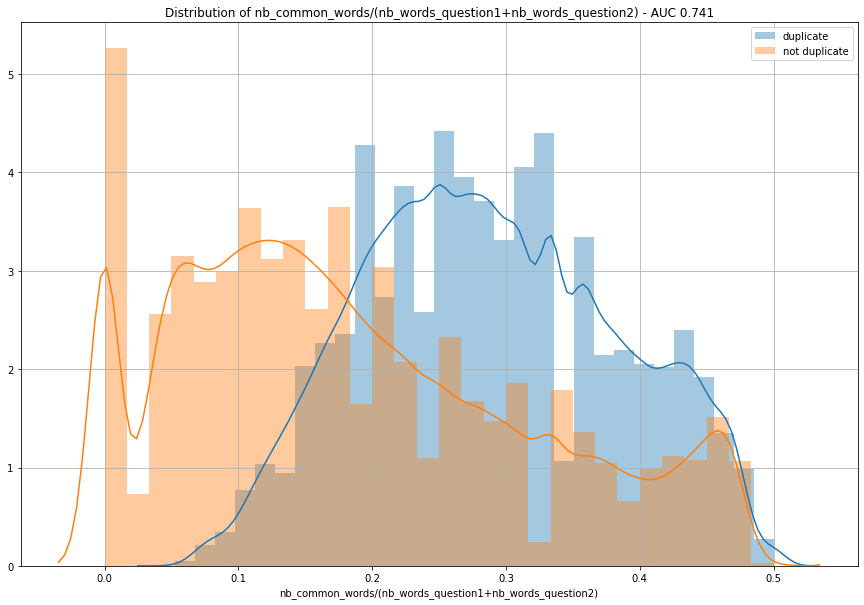

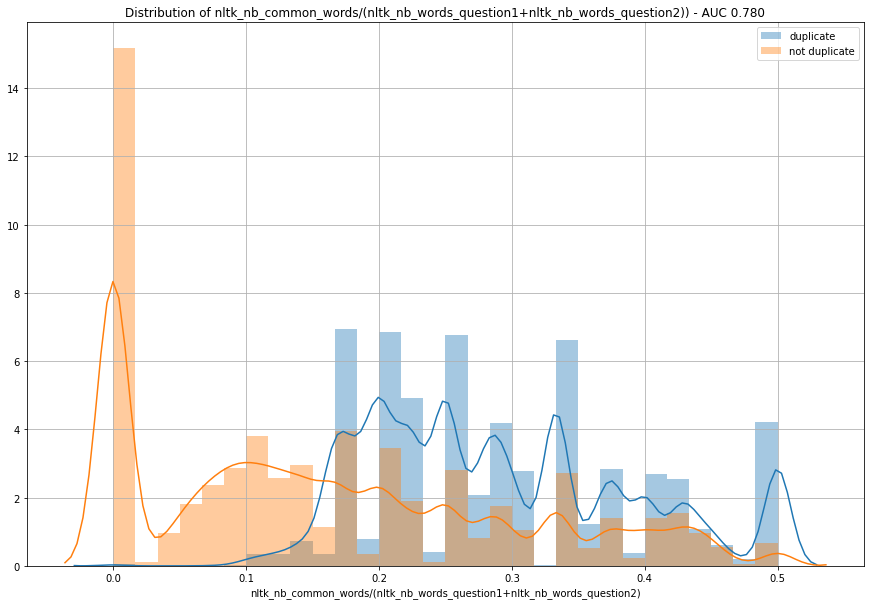

In [17]:
plot.figure(figsize=(15,10))
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==1]['nb_common_words/(nb_words_question1+nb_words_question2)'], bins=30, label='duplicate', kde=True)  
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==0]['nb_common_words/(nb_words_question1+nb_words_question2)'], bins=30,   label='not duplicate', kde=True)
plot.title('Distribution of nb_common_words/(nb_words_question1+nb_words_question2) - AUC %.3f' %simple_weighted_AUC(train_dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)'))
plot.grid(True)
plot.legend()
plot_save('distribution_ratio_no_stopwords')

plot.figure(figsize=(15,10))
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==1]['nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)'], bins=30, label='duplicate', kde=True)    
sns.distplot(train_dataframe[train_dataframe['is_duplicate']==0]['nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)'], bins=30,   label='not duplicate', kde=True)
plot.title('Distribution of nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)) - AUC %.3f' %simple_weighted_AUC(train_dataframe,'nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)'))
plot.grid(True)
plot.legend()
plot_save('distribution_ratio_nltk_stopwords')


Just focus on the correlation matrix of non semantic features

is_duplicate                                                                                1.000000
all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)                         0.456488
nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)                      0.456047
all_nb_common_words/all_nb_words_question1                                                  0.447348
nltk_nb_common_words/nltk_nb_words_question1                                                0.445528
all_nb_common_words/all_nb_words_question2                                                  0.440822
nltk_nb_common_words/nltk_nb_words_question2                                                0.440107
lemmatized_nb_common_words/(lemmatized_nb_words_question1+lemmatized_nb_words_question2)    0.423128
clean_all_nb_common_words/(clean_all_nb_words_question1+clean_all_nb_words_question2)       0.422021
clean_all_nb_common_words/clean_all_nb_words_question1                                     

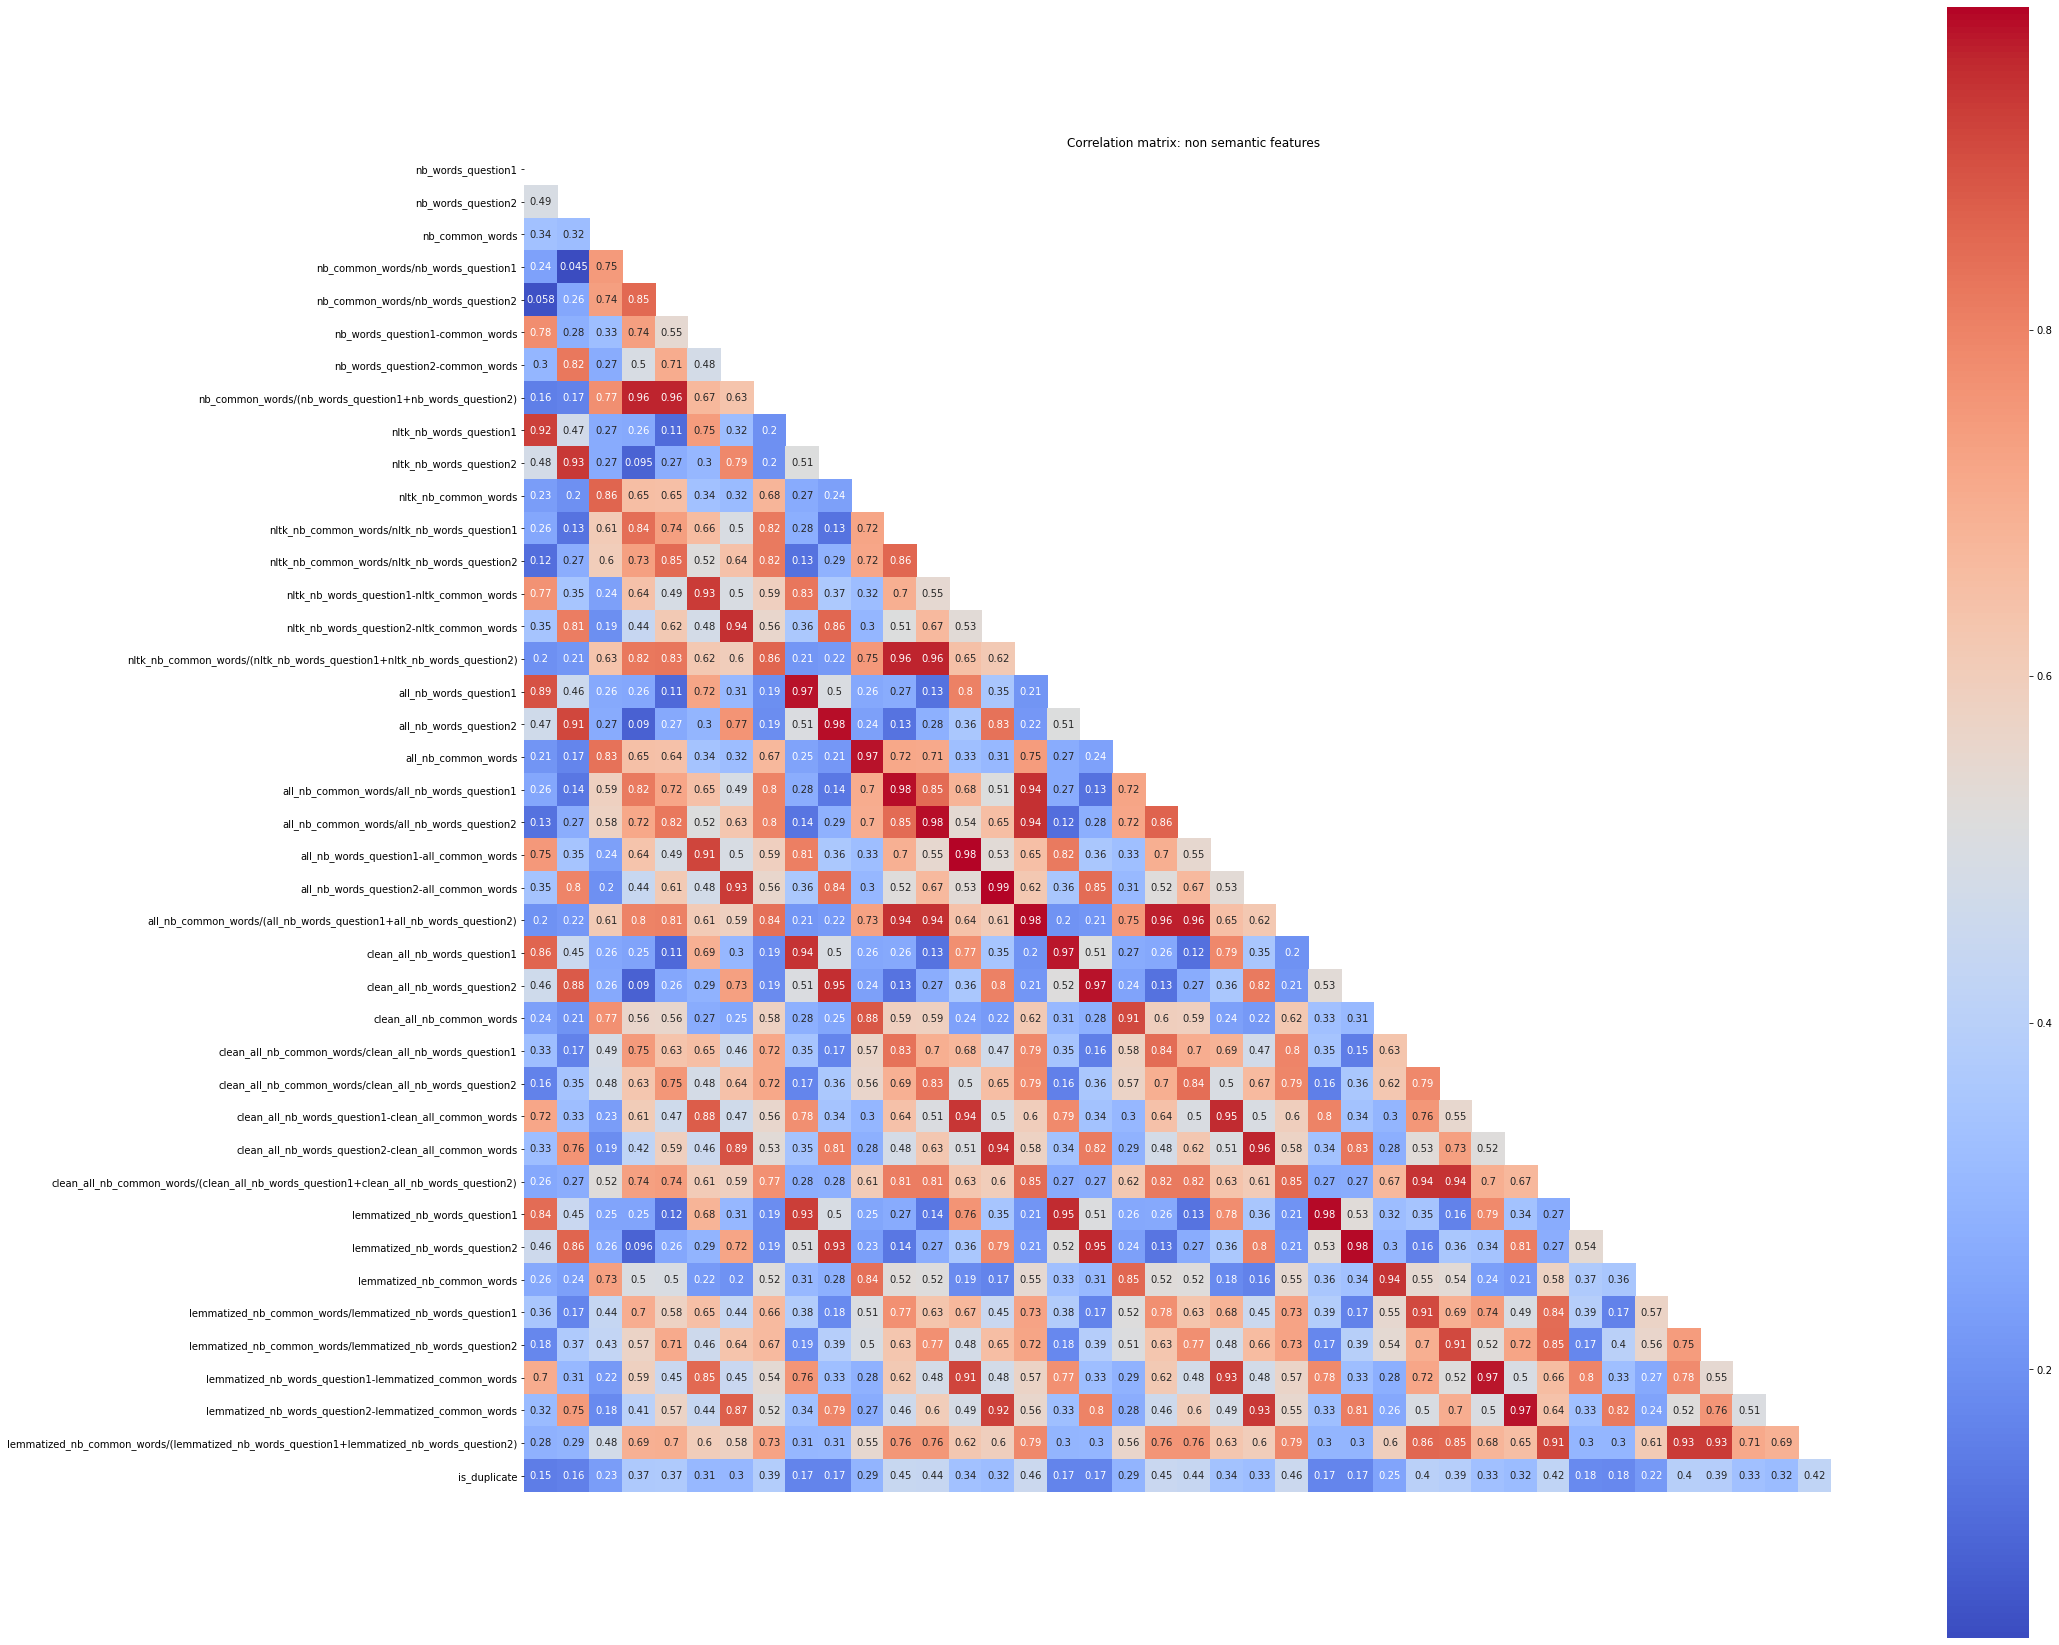

In [18]:
    def show_correlation_matrix(input_df,columns):
        correlation_matrix = input_df[columns].corr().abs()
        print(correlation_matrix['is_duplicate'].nlargest(len(columns)))

        correlation_matrix_without_is_duplicate = correlation_matrix['is_duplicate'][correlation_matrix['is_duplicate']<1]
        highest_correlated_feature = correlation_matrix_without_is_duplicate.nlargest(1).index[0]
        highest_correlation = correlation_matrix_without_is_duplicate.nlargest(1)[0]
        if highest_correlation >0.2:
            if highest_correlation < 0.5:
                print_warning('%s is the most correlated with target but %f is quite weak' % (highest_correlated_feature,highest_correlation))
            else:
                print_info('%s is the most correlated with target but %f is very weak' % (highest_correlated_feature,highest_correlation))
        else:
            print_alert('%s is the most correlated with target and %f is quite big' % (highest_correlated_feature,highest_correlation))
        plot.figure(figsize=(30, 30))
        plot.title('Correlation matrix: non semantic features')
        sns.heatmap(correlation_matrix,annot=True,cbar=True,square=True,cmap='coolwarm',mask = numpy.triu(correlation_matrix),xticklabels=False)
        
    NON_SEMANTIC_FEATURES = [c for c in all_numeric_columns(train_dataframe) if 'entities' not in c and 'news' not in c and 'proba' not in c and 'sim' not in c] 
    NON_SEMANTIC_FEATURES.append('is_duplicate')

    show_correlation_matrix(train_dataframe,NON_SEMANTIC_FEATURES)
    plot_save('correlation_matrix_non_semantic_features')

Let's recap our available features

In [19]:
ALL_FEATURES=all_numeric_columns(train_dataframe)
print_info('We have %d features' % len(ALL_FEATURES))
display(pandas.DataFrame(ALL_FEATURES,columns=['feature']))

feature
0                    nb_words_question1
1                    nb_words_question2
2                       nb_common_words
3    nb_common_words/nb_words_question1
4    nb_common_words/nb_words_question2
..                                  ...
98             proba_vehicles_question2
99                proba_sport_question2
100             proba_science_question2
101            proba_politics_question2
102                    spacy_similarity

[103 rows x 1 columns]

Exploring each combination of these 103 features (like we did in a first experiment with basic features) is not practical. We will just add one field at a time, build a model, keep metrics and figure what is happening.

A bunch of code to build xgboost models with basic set of parameters
The criteria to stop learning is aligned to kaggle's one: *logloss*

In [20]:
# Simple XGBoost code
# 

import xgboost 

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta' : 0.02,
    'max_depth':3 
    }

def print_res_xgboost(infos):
    # Glurk
    print_info(' | '.join([('%s '+f) % (k,infos[k]) for k,f in INFO_XGBOOST_MODEL.items() if k in infos]))

# 80% training 20% validation
def build_XGBoost_model_80_20(training,target,column_names,show=True):
    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT],nthread = -1)
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT])
    watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params,train_dm,400,watchlist,early_stopping_rounds=50,verbose_eval=verbose)
    infos = compute_metrics_model_xgboost(model,final_input_test,target_test,sample_weight = input_test[WEIGHT],show=show)
    duration = time.time()-start
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

# Pushing the limits :100 % training no validation !!
# Just in case it allows to gain small digits in kaggle score...
# Actually not used ...
def build_XGBoost_model_100_0(training,target,column_names,show=True):
    final_train = training[list(column_names)]
    final_target = target
    final_weight = training[WEIGHT]

    train_dm = xgboost.DMatrix(final_train, label = final_target, weight = final_weight,nthread = -1)
    watchlist = [(train_dm, 'train')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params,train_dm,400,watchlist,early_stopping_rounds=50,verbose_eval=verbose)
    duration = time.time()-start
    infos = compute_metrics_model_xgboost(model,final_train,final_target,sample_weight = final_weight,show=show)
    infos.update({'time':duration})
    if show:      
        print_res_xgboost(infos)
    return  infos

def compute_metrics_model_xgboost(model,input_df,target_df,sample_weight = None,show = True):
    final_input = xgboost.DMatrix(input_df)
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    # Hum shouldn't we challenge this 50% threshold ?
    prediction_df = numpy.where(prediction_proba_df>0.5,1,0)
    res = metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight = sample_weight)
    if show:
        print_info('Classification report')
        print(metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight))
    return {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           }

INFO_XGBOOST_MODEL= {
    'logloss_proba': '%.4f',
    'score': '%.4f',
    'accuracy': '%.4f',
    'time': '%.2f'
}

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 100_0')
    res = build_XGBoost_model_100_0(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 80_20')
    res = build_XGBoost_model_80_20(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

[0]	train-logloss:0.68197
Will train until train-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.59052
[20]	train-logloss:0.52561
[30]	train-logloss:0.47742
[40]	train-logloss:0.44053
[50]	train-logloss:0.41196
[60]	train-logloss:0.38937
[70]	train-logloss:0.37119
[80]	train-logloss:0.35641
[90]	train-logloss:0.34403
[100]	train-logloss:0.33386
[110]	train-logloss:0.32538
[120]	train-logloss:0.31837
[130]	train-logloss:0.31260
[140]	train-logloss:0.30742
[150]	train-logloss:0.30306
[160]	train-logloss:0.29905
[170]	train-logloss:0.29543
[180]	train-logloss:0.29147
[190]	train-logloss:0.28824
[200]	train-logloss:0.28496
[210]	train-logloss:0.28219
[220]	train-logloss:0.27950
[230]	train-logloss:0.27681
[240]	train-logloss:0.27440
[250]	train-logloss:0.27193
[260]	train-logloss:0.26959
[270]	train-logloss:0.26718
[280]	train-logloss:0.26491
[290]	train-logloss:0.26270
[300]	train-logloss:0.26005
[310]	train-logloss:0.25779
[320]	train-logloss:0.25567
[330]	train-logloss:0.2532

              precision    recall  f1-score   support

           0       0.90      0.99      0.94 833.5098453967706
           1       0.91      0.44      0.59 171.66892895091271

    accuracy                           0.90 1005.1787743476833
   macro avg       0.90      0.71      0.77 1005.1787743476833
weighted avg       0.90      0.90      0.88 1005.1787743476833



{'accuracy': 0.896211440802916, 'score': 0.8807751385786928, 'logloss_proba': 0.2393331575206632, 'model': <xgboost.core.Booster object at 0x7f4e97ea0df0>, 'time': 3.049307346343994}


[0]	train-logloss:0.68206	valid-logloss:0.68148
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.59137	valid-logloss:0.58652
[20]	train-logloss:0.52546	valid-logloss:0.52009
[30]	train-logloss:0.47733	valid-logloss:0.47161
[40]	train-logloss:0.44085	valid-logloss:0.43516
[50]	train-logloss:0.41232	valid-logloss:0.40764
[60]	train-logloss:0.38952	valid-logloss:0.38625
[70]	train-logloss:0.37149	valid-logloss:0.36966
[80]	train-logloss:0.35681	valid-logloss:0.35688
[90]	train-logloss:0.34513	valid-logloss:0.34702
[100]	train-logloss:0.33566	valid-logloss:0.33890
[110]	train-logloss:0.32748	valid-logloss:0.33316
[120]	train-logloss:0.32087	valid-logloss:0.32869
[130]	train-logloss:0.31489	valid-logloss:0.32502
[140]	train-logloss:0.30967	valid-logloss:0.32275
[150]	train-logloss:0.30537	valid-logloss:0.32034
[160]	train-logloss:0.30110	valid-logloss:0.31875
[170]	trai

              precision    recall  f1-score   support

           0       0.85      0.95      0.90 168.7955573880411
           1       0.42      0.17      0.24 33.5771183347514

    accuracy                           0.82 202.37267572279248
   macro avg       0.64      0.56      0.57 202.37267572279248
weighted avg       0.78      0.82      0.79 202.37267572279248



{'accuracy': 0.8233305536485764, 'score': 0.7906801062261981, 'logloss_proba': 0.31272589442104753, 'model': <xgboost.core.Booster object at 0x7f4e97ea0820>, 'time': 11.76548457145691}


Before launching bigh models, let's check again what we have.
Here are the numeric columns (ids and target have been removed) in train dataset

In [21]:
assert all_numeric_columns(train_dataframe) == all_numeric_columns(challenge_dataframe), 'Oups train and challenge do not have the same numeric columns'
print_info('train and challenge datasets have the same numeric columns ')
i = 1
for c in all_numeric_columns(train_dataframe):
    print(i,c)
    i +=1



1 nb_words_question1
2 nb_words_question2
3 nb_common_words
4 nb_common_words/nb_words_question1
5 nb_common_words/nb_words_question2
6 nb_words_question1-common_words
7 nb_words_question2-common_words
8 nb_common_words/(nb_words_question1+nb_words_question2)
9 nltk_nb_words_question1
10 nltk_nb_words_question2
11 nltk_nb_common_words
12 nltk_nb_common_words/nltk_nb_words_question1
13 nltk_nb_common_words/nltk_nb_words_question2
14 nltk_nb_words_question1-nltk_common_words
15 nltk_nb_words_question2-nltk_common_words
16 nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)
17 all_nb_words_question1
18 all_nb_words_question2
19 all_nb_common_words
20 all_nb_common_words/all_nb_words_question1
21 all_nb_common_words/all_nb_words_question2
22 all_nb_words_question1-all_common_words
23 all_nb_words_question2-all_common_words
24 all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)
25 clean_all_nb_words_question1
26 clean_all_nb_words_question2
27 clean_all_nb

Let's check again the impact of entities

In [22]:
ALL_NB_ENTITIES=[c for c in all_numeric_columns(train_dataframe) if 'enti' in c and 'ratio' not in c]
print(ALL_NB_ENTITIES)
def sniff_entities(r):
    for c in ALL_NB_ENTITIES:
        if r[c]>0:
            return 1
    return 0

res = train_dataframe.progress_apply(sniff_entities,axis=1)
print_info('%.2f %% of pairs have some detected entities' % (res.mean()*100.))




['nb_entities_GPE_question1', 'nb_entities_PERSON_question1', 'nb_entities_PRODUCT_question1', 'nb_entities_ORG_question1', 'nb_entities_DATE_question1', 'nb_entities_NORP_question1', 'nb_entities_WORK_OF_ART_question1', 'nb_entities_LANGUAGE_question1', 'nb_entities_EVENT_question1', 'nb_entities_FAC_question1', 'nb_entities_LAW_question1', 'nb_entities_LOC_question1', 'nb_entities_GPE_question2', 'nb_entities_PERSON_question2', 'nb_entities_PRODUCT_question2', 'nb_entities_ORG_question2', 'nb_entities_DATE_question2', 'nb_entities_NORP_question2', 'nb_entities_WORK_OF_ART_question2', 'nb_entities_LANGUAGE_question2', 'nb_entities_EVENT_question2', 'nb_entities_FAC_question2', 'nb_entities_LAW_question2', 'nb_entities_LOC_question2', 'nb_entities_common_GPE', 'nb_entities_common_PERSON', 'nb_entities_common_PRODUCT', 'nb_entities_common_ORG', 'nb_entities_common_DATE', 'nb_entities_common_NORP', 'nb_entities_common_WORK_OF_ART', 'nb_entities_common_LANGUAGE', 'nb_entities_common_EVENT

Another bunch of code. Just wrappers so we do in one shot:
* generate a set of models given a set of columns
* keep their results in memory
* save all models to excel
* dump everything (including the models) in a cache so all previous steps can be done in a sec
* find the best model (related to logloss)
* generate a file of predictions suitable for kaggle
* prepare everything for a kaggle submission
* show the statement to do the submission to kaggle


Current exploration methods available, given n columns
* generate models using from 1 to n columns (24 columns will generate 24 models)
* only one model with all the columns provided as parameter

In [23]:
def find_best_result(results,metric):
    if 'logloss' in metric:
        return results.nsmallest(1,metric)
    else:
        return results.nlargest(1,metric)
        
def apply_xgboost(model,columns,input_df):
    res = pandas.DataFrame()
    res['test_id'] = input_df['test_id']
    res['is_duplicate'] = model.predict(xgboost.DMatrix(input_df[columns]))
    return res

def submit_best_result(results,input_df,file_name,kaggle_message,metric='logloss_proba'):
    start = time.time()
    print_section("Scoring XGBoost model with best %s: %s" % (metric,kaggle_message))
    csv_file_name = absolute_env_file_name(file_name,ext='.csv')
    print_info('Generating scores in %s' % csv_file_name)
    best = find_best_result(results,metric)
    model = best['model'][0]
    columns = best['columns'][0]
    prediction = apply_xgboost(model,columns,input_df)
    prediction.to_csv(csv_file_name,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(csv_file_name)
    print_done('Done',top=start)
    print_info('%s is ready' % absolute_file_name_zip)
    print_warning('Use this commands to submit apply results to kaggle')
    print_warning('kaggle competitions submit quora-question-pairs -f "%s" -m "%s %s"' % (absolute_file_name_zip,EXPERIMENT,kaggle_message))
    return prediction

def n_columns(columns,n):
    return columns[0:n]

def xgboost_80_20_one_more_field_at_a_time(dataframe,columns_to_explore,explore=True,show=False):
    if explore:
        print_section("XGBoost (80,20) on 1 to %d fields" % len(columns_to_explore))
    else:
        print_section("XGBoost (80,20) on %d fields" % len(columns_to_explore))
    start = time.time()
    res_final = dict()
    min_log_loss = 1000
    best = 0
    best_cols =''
    # a shortcut is possible
    if explore:
        first_nb = 1
    else:
        first_nb=len(columns_to_explore)
    for i in tqdm(range(first_nb,len(columns_to_explore)+1)):
        columns = n_columns(columns_to_explore,i)
        res = build_XGBoost_model_80_20(dataframe,dataframe['is_duplicate'],columns,show = show)
        cur_logloss = res['logloss_proba']
        cur_accuracy = res['accuracy']
        cur_score = res['score']
        if cur_logloss<min_log_loss:
            print_info("%d:%.4f %.4f %.4f %s" % (i,cur_logloss,cur_accuracy,cur_score,columns))
            min_log_loss = cur_logloss
            best_cols = columns
            best = i
        else:
            print_warning("%d:%.4f %.4f %.4f %s" % (i,cur_logloss,cur_accuracy,cur_score,columns))
        res.update( {'columns':columns})
        res_final.update({str(i):res})
    print_info('Best: %d %.4f %s' % (best,min_log_loss,best_cols))
    print_done('Done',top=start)
    return pandas.DataFrame.from_dict(res_final, orient='index')

# try to reload from cache an exploration
# if not available, redo it and save results in cache
# find the best result according to a metric (default logloss_proba)
# and submit it to kaggle
def study_models_one_more_field_at_a_time(message,tag,columns,train_df,challenge_df,explore=True,show=False):
    print_section(message)
    results = load_or_build_dataframe('Rebuild XGBoost models',tag + '_results',lambda df:xgboost_80_20_one_more_field_at_a_time(df,columns,explore=explore,show=show),train_df)
    save_models_dict_to_excel(results,tag=tag)
    display(results.describe())
    submit_best_result(results,challenge_df,'Best_'+tag,'Best ' + tag)
    return results

A little bit long but results are saved in a cache so next time will be fast

In [24]:
xgboost_everything_results = study_models_one_more_field_at_a_time(
    'all features_not_cleaned',
    'all_features_not_cleaned',
    ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore = True,
    show = False)

accuracy       score  logloss_proba        time
count  103.000000  103.000000     103.000000  103.000000
mean     0.831769    0.777745       0.339411   46.778275
std      0.003344    0.012868       0.020241   20.324604
min      0.823848    0.744278       0.329115   13.540899
25%      0.829115    0.767438       0.331423   31.004554
50%      0.833975    0.786215       0.331551   45.348167
75%      0.834088    0.786437       0.338668   56.503787
max      0.834297    0.786997       0.454579  106.995749

We graph the logloss obtained adding one field at a time from:
* basic features on non processed data
* same features with a first set of stop words removed
* same features with more stop words removed
* same features with more stop words after cleaning
* same features with more stop words after cleaning and lemmatisation
* Entities 
* newsgroups
* similarity computed by spacy lib

Obviously, this graph does not prove anything as another order of fields would generate a totally different graph but we can still say:
* all preprocessing informations provide some enhancement
* expanding list of stop words provides only marginal enhancement. **Again**, this does not mean features built with full list of stop words does not provide informations. It does provide a little bit more information to the ones already available
* lemmatisation is useful in our context
* entities do not provide much more informations
* spacy similarity does enhance the model but not dramatically
* optimising hyperparameters is quite efficient

Challenging the need of a feature on the final model is done later

Let's start with all non semantic features

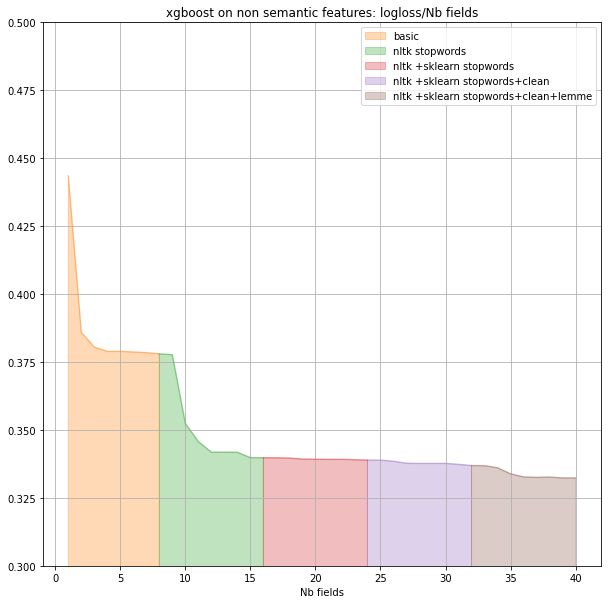

In [25]:
plot.figure(figsize=(10,10))

pal=sns.color_palette()
plot.ylim(0.3,0.5)
plot.plot(numpy.arange(1,9,1),xgboost_everything_results['logloss_proba'][1:9],color=pal[1],alpha=0.3)
plot.fill_between(numpy.arange(1,9,1),xgboost_everything_results['logloss_proba'][1:9],label='basic',color=pal[1],alpha=0.3)

plot.plot(numpy.arange(8,17,1),xgboost_everything_results['logloss_proba'][8:17],color=pal[2],alpha=0.3)
plot.fill_between(numpy.arange(8,17,1),xgboost_everything_results['logloss_proba'][8:17],label='nltk stopwords',color=pal[2],alpha=0.3)

plot.plot(numpy.arange(16,25,1),xgboost_everything_results['logloss_proba'][16:25],color=pal[3],alpha=0.3)
plot.fill_between(numpy.arange(16,25,1),xgboost_everything_results['logloss_proba'][16:25],label='nltk +sklearn stopwords',color=pal[3],alpha=0.3)

plot.plot(numpy.arange(24,33,1),xgboost_everything_results['logloss_proba'][24:33],color=pal[4],alpha=0.3)
plot.fill_between(numpy.arange(24,33,1),xgboost_everything_results['logloss_proba'][24:33],label='nltk +sklearn stopwords+clean',color=pal[4],alpha=0.3)

plot.plot(numpy.arange(32,41,1),xgboost_everything_results['logloss_proba'][32:41],color=pal[5],alpha=0.3)
plot.fill_between(numpy.arange(32,41,1),xgboost_everything_results['logloss_proba'][32:41],label='nltk +sklearn stopwords+clean+lemme',color=pal[5],alpha=0.3)

plot.title('xgboost on non semantic features: logloss/Nb fields')
plot.xlabel('Nb fields')
plot.grid(True)
plot.legend()
plot_save('xgboost_all_features_all_preprocess_non_semantic')

Now, let's plot the model with semantic features : entities+newsgroup+similarity

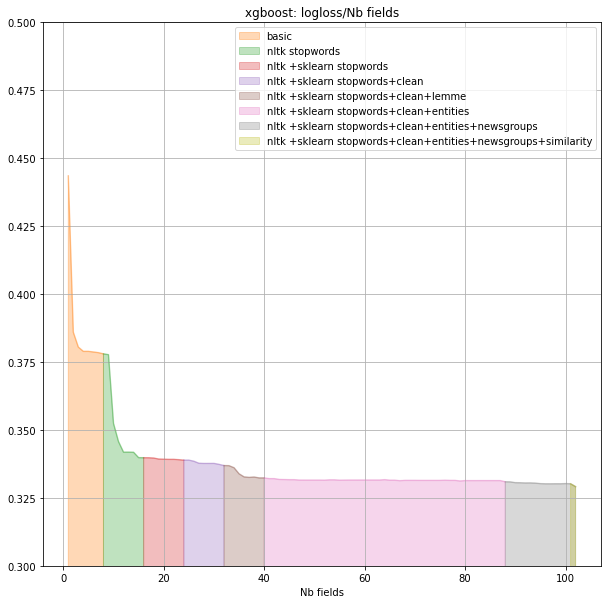

In [26]:

plot.figure(figsize=(10,10))

pal=sns.color_palette()
plot.ylim(0.3,0.5)
plot.plot(numpy.arange(1,9,1),xgboost_everything_results['logloss_proba'][1:9],color=pal[1],alpha=0.3)
plot.fill_between(numpy.arange(1,9,1),xgboost_everything_results['logloss_proba'][1:9],label='basic',color=pal[1],alpha=0.3)

plot.plot(numpy.arange(8,17,1),xgboost_everything_results['logloss_proba'][8:17],color=pal[2],alpha=0.3)
plot.fill_between(numpy.arange(8,17,1),xgboost_everything_results['logloss_proba'][8:17],label='nltk stopwords',color=pal[2],alpha=0.3)

plot.plot(numpy.arange(16,25,1),xgboost_everything_results['logloss_proba'][16:25],color=pal[3],alpha=0.3)
plot.fill_between(numpy.arange(16,25,1),xgboost_everything_results['logloss_proba'][16:25],label='nltk +sklearn stopwords',color=pal[3],alpha=0.3)

plot.plot(numpy.arange(24,33,1),xgboost_everything_results['logloss_proba'][24:33],color=pal[4],alpha=0.3)
plot.fill_between(numpy.arange(24,33,1),xgboost_everything_results['logloss_proba'][24:33],label='nltk +sklearn stopwords+clean',color=pal[4],alpha=0.3)

plot.plot(numpy.arange(32,41,1),xgboost_everything_results['logloss_proba'][32:41],color=pal[5],alpha=0.3)
plot.fill_between(numpy.arange(32,41,1),xgboost_everything_results['logloss_proba'][32:41],label='nltk +sklearn stopwords+clean+lemme',color=pal[5],alpha=0.3)

plot.plot(numpy.arange(40,89,1),xgboost_everything_results['logloss_proba'][40:89],color=pal[6],alpha=0.3)
plot.fill_between(numpy.arange(40,89,1),xgboost_everything_results['logloss_proba'][40:89],label='nltk +sklearn stopwords+clean+entities',color=pal[6],alpha=0.3)

plot.plot(numpy.arange(88,103,1),xgboost_everything_results['logloss_proba'][88:103],color=pal[7],alpha=0.3)
plot.fill_between(numpy.arange(88,103,1),xgboost_everything_results['logloss_proba'][88:103],label='nltk +sklearn stopwords+clean+entities+newsgroups',color=pal[7],alpha=0.3)

plot.plot(numpy.arange(101,103,1),xgboost_everything_results['logloss_proba'][101:103],color=pal[8],alpha=0.3)
plot.fill_between(numpy.arange(101,103,1),xgboost_everything_results['logloss_proba'][101:103],label='nltk +sklearn stopwords+clean+entities+newsgroups+similarity',color=pal[8],alpha=0.3)
plot.title('xgboost: logloss/Nb fields')
plot.xlabel('Nb fields')
plot.grid(True)
plot.legend()
plot_save('all_features_all_preprocess')

We have now a model using all features (even if we know some features provide only small information)

Let's optimize this model by searching bets set of hyperparameters.

We have use hyperopt library to search the best model between 500 models exploring a vast set of parameters.

Each model is evaluated on its logloss : we keep following the kaggle challenge

In [27]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

def hyperopt_optimize(training,target,column_names,trials,show=False):

    parameters_space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', numpy.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        'nthread': 8,
        #'booster': 'gbtree',
        #'tree_method': 'exact',
        'seed': 42,
        "seed_per_iteration": True,
        "tree_method": "hist"
    }

    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT],nthread = -1)
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT])
    watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    def eval_model(params):
        num_round = int(params['n_estimators'])
        del params['n_estimators']
        model = xgboost.train(params,train_dm,num_round,watchlist,early_stopping_rounds=50,verbose_eval=show)
        prediction_proba_df = model.predict(validation_dm,ntree_limit=model.best_iteration + 1)
        logloss = metrics.log_loss(target_test,prediction_proba_df,sample_weight = input_test[WEIGHT])
        return {'loss': logloss, 'status': STATUS_OK, 'model' : model, 'logloss':logloss}

    # Use the hyperopt's fmin
    start = time.time()
    print_section('Finding hyperparameters')
    best = fmin(eval_model, parameters_space, algo=tpe.suggest, 
                trials=trials, 
                max_evals=500)
    print_done('Done',top=start)
    return best

ModuleNotFoundError: No module named 'hyperopt'

Do not do it : it takes 10 hours on a 8 cores server

In [ ]:
DO_HYPER_OPTIM=False

if DO_HYPER_OPTIM:
    trials = Trials()
    best_xgboost_parameters = hyperopt_optimize(train_dataframe,train_dataframe['is_duplicate'],ALL_FEATURES,trials,show=False)
    # from hyperopt's sources ....
    plot.figure(figsize=(10,10))
    plot.scatter(range(len(trials.losses())), trials.losses())
    plot.xlabel("time")
    plot.ylabel("logloss")
    plot.grid(True)
    print("avg best error:", best_err)
    plot.axhline(best_err, c="g",label='avg best error')
    plot.legend()
    plot.title('Hyperopt on final model: logloss history')
    plot_save('hyperopt_history')

    #hyperopt.plotting.main_plot_histogram(trials)
    #hyperopt.plotting.main_plot_vars(trials)
    best_xgboost_parameters


Here are the best parameters:
* colsample_bytree: 0.7000000000000001,
* eta: 0.05,
* gamma: 0.8500000000000001,
* max_depth: 11,
* min_child_weight: 3.0,
* n_estimators: 868.0,
* subsample: 0.9500000000000001}

Let's redo this best model with our 'framework'

In [28]:
params= {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'colsample_bytree': 0.7000000000000001,
    'eta': 0.05,
    'gamma': 0.8500000000000001,
    'max_depth': 11,
    'min_child_weight': 3.0,
    'n_estimators': 868.0,
    'subsample': 0.9500000000000001}

xgboost_best_optim = study_models_one_more_field_at_a_time(
    'all features all_preprocess optim',
    'all_features_all_preprocess_optim',
    ALL_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore = False,
    show = False)

[09:20:51] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




accuracy     score  logloss_proba        time
count  1.000000  1.000000       1.000000    1.000000
mean   0.861355  0.846655       0.286021  282.659022
std         NaN       NaN            NaN         NaN
min    0.861355  0.846655       0.286021  282.659022
25%    0.861355  0.846655       0.286021  282.659022
50%    0.861355  0.846655       0.286021  282.659022
75%    0.861355  0.846655       0.286021  282.659022
max    0.861355  0.846655       0.286021  282.659022

Let's add this optimized model to the previous plot

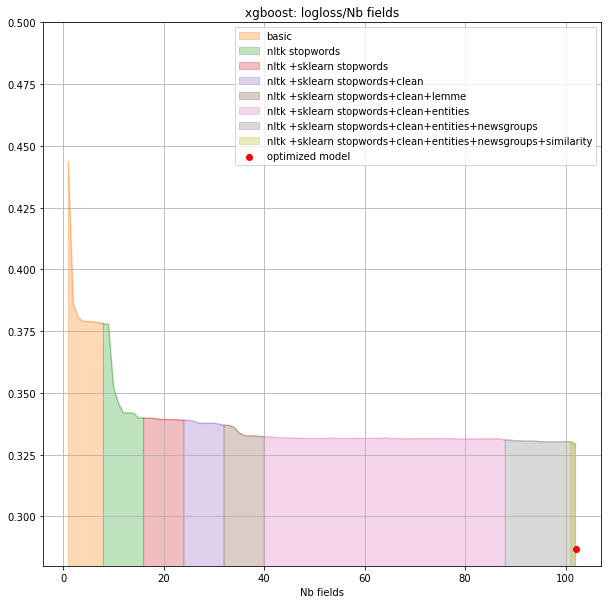

In [29]:
plot.figure(figsize=(10,10))

pal=sns.color_palette()
plot.ylim(0.28,0.5)
plot.plot(numpy.arange(1,9,1),xgboost_everything_results['logloss_proba'][1:9],color=pal[1],alpha=0.3)
plot.fill_between(numpy.arange(1,9,1),xgboost_everything_results['logloss_proba'][1:9],label='basic',color=pal[1],alpha=0.3)

plot.plot(numpy.arange(8,17,1),xgboost_everything_results['logloss_proba'][8:17],color=pal[2],alpha=0.3)
plot.fill_between(numpy.arange(8,17,1),xgboost_everything_results['logloss_proba'][8:17],label='nltk stopwords',color=pal[2],alpha=0.3)

plot.plot(numpy.arange(16,25,1),xgboost_everything_results['logloss_proba'][16:25],color=pal[3],alpha=0.3)
plot.fill_between(numpy.arange(16,25,1),xgboost_everything_results['logloss_proba'][16:25],label='nltk +sklearn stopwords',color=pal[3],alpha=0.3)

plot.plot(numpy.arange(24,33,1),xgboost_everything_results['logloss_proba'][24:33],color=pal[4],alpha=0.3)
plot.fill_between(numpy.arange(24,33,1),xgboost_everything_results['logloss_proba'][24:33],label='nltk +sklearn stopwords+clean',color=pal[4],alpha=0.3)

plot.plot(numpy.arange(32,41,1),xgboost_everything_results['logloss_proba'][32:41],color=pal[5],alpha=0.3)
plot.fill_between(numpy.arange(32,41,1),xgboost_everything_results['logloss_proba'][32:41],label='nltk +sklearn stopwords+clean+lemme',color=pal[5],alpha=0.3)

plot.plot(numpy.arange(40,89,1),xgboost_everything_results['logloss_proba'][40:89],color=pal[6],alpha=0.3)
plot.fill_between(numpy.arange(40,89,1),xgboost_everything_results['logloss_proba'][40:89],label='nltk +sklearn stopwords+clean+entities',color=pal[6],alpha=0.3)

plot.plot(numpy.arange(88,103,1),xgboost_everything_results['logloss_proba'][88:103],color=pal[7],alpha=0.3)
plot.fill_between(numpy.arange(88,103,1),xgboost_everything_results['logloss_proba'][88:103],label='nltk +sklearn stopwords+clean+entities+newsgroups',color=pal[7],alpha=0.3)

plot.plot(numpy.arange(101,103,1),xgboost_everything_results['logloss_proba'][101:103],color=pal[8],alpha=0.3)
plot.fill_between(numpy.arange(101,103,1),xgboost_everything_results['logloss_proba'][101:103],label='nltk +sklearn stopwords+clean+entities+newsgroups+similarity',color=pal[8],alpha=0.3)

plot.scatter(102,0.2867,color="red",label='optimized model')
plot.title('xgboost: logloss/Nb fields')
plot.xlabel('Nb fields')
plot.grid(True)
plot.legend()
plot_save('all_features_all_preprocess_optimized')

What does Kaggle think about that model ?


In [31]:
all_submissions = load_kaggle_submissions()

EmptyDataError: No columns to parse from file

In [ ]:
get_last_submissions(all_submissions,10)

Ok We have a model quite acceptable for kaggle (in the first 33%)

Is it really a good model ? Kaggle score does not imply it is a good model

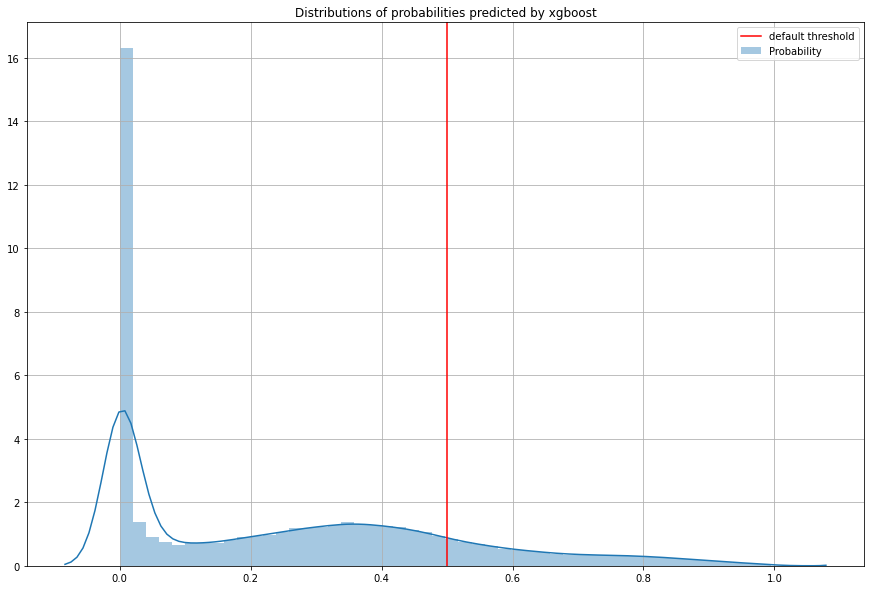

In [33]:
model = xgboost_best_optim['model'][0]
# do the usual split (80,20)
input_train,input_test,target_train,target_test = train_test_split(train_dataframe,train_dataframe['is_duplicate'],random_state=42,test_size=0.2)
test_probabilities = model.predict(xgboost.DMatrix(input_test[ALL_FEATURES]),ntree_limit=model.best_ntree_limit)
train_probabilities = model.predict(xgboost.DMatrix(input_train[ALL_FEATURES]),ntree_limit=model.best_ntree_limit)
challenge_probabilities = model.predict(xgboost.DMatrix(challenge_dataframe[ALL_FEATURES]),ntree_limit=model.best_ntree_limit)

# Apply the standard threshold
test_predictions = numpy.where(test_probabilities>0.5,1,0)
train_predictions = numpy.where(train_probabilities>0.5,1,0)
challenge_predictions = numpy.where(challenge_probabilities>0.5,1,0)

# What do we have in predictions
print_info('On test %% of true duplicates is %.3f' % (target_test.mean()*100.))
print_warning('On test %% of predicted duplicates is %.3f !!' % (test_predictions.mean()*100.))

print_info('On train %% of true duplicates is %.3f' % (target_train.mean()*100.))
print_warning('On train %% of predicted duplicates is %.3f !!' % (train_predictions.mean()*100.))

print_warning('On challenge %% of predicted duplicates is %.3f !!' % (challenge_predictions.mean()*100.))

plot.figure(figsize=(15,10))
sns.distplot(test_probabilities,label='Probability', kde=True)
plot.axvline(x=0.5,color='r',label='default threshold')
plot.legend()
plot.grid(True)
plot.title("Distributions of probabilities predicted by xgboost")
plot_save('distribution_uncalibrated_probabilities_xgboost')

What about the confusion matrix

              precision    recall  f1-score   support

           0       0.88      0.96      0.92 66475.35427891841
           1       0.68      0.40      0.51 14213.525233116525

    accuracy                           0.86 80688.87951203494
   macro avg       0.78      0.68      0.71 80688.87951203494
weighted avg       0.85      0.86      0.85 80688.87951203494



<Figure size 720x720 with 0 Axes>

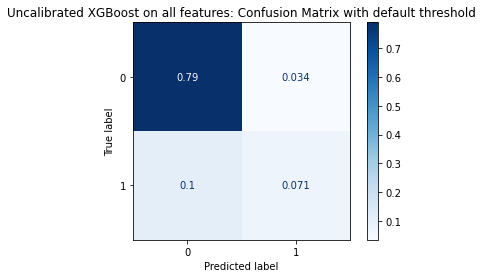

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def show_confusion_matrix(model,columns,input,target):
    input_train,input_test,target_train,target_test = train_test_split(input,target,random_state=42,test_size=0.2)
    input_train_weight = input_train['weight']
    input_test_weight = input_test['weight']

    test_probabilities = model.predict(xgboost.DMatrix(input_test[columns]),ntree_limit=model.best_ntree_limit)

    test_predictions = numpy.where(test_probabilities>0.5,1,0)
    # Last minute check
    nb_0 = numpy.where(test_predictions==0,1,0).sum()
    nb_1 = numpy.where(test_predictions==1,1,0).sum()
    assert (nb_1+nb_0) == len(test_predictions)

    print_info('Performances')
    print(metrics.classification_report(target_test,test_predictions,sample_weight=input_test_weight))
    print_warning('%% prediction of is_duplicate=1 in test !!! : %.3f' % (test_predictions.mean()*100.))
    logloss_proba = metrics.log_loss(target_test,test_probabilities,sample_weight=input_test_weight,normalize=True)
    print_warning('logloss in test %.3f' % logloss_proba)

    # display cool graphs
    #plot.figure(figsize=(10, 10))
    #fig,ax = plot.subplots()
    #uncalibrated_confusion_matrix = confusion_matrix(target_test,test_predictions,sample_weight=input_test_weight)
    #ConfusionMatrixDisplay(uncalibrated_confusion_matrix).plot(cmap=plot.cm.Blues,values_format=".0f",ax=ax)
    #plot.title('Default XGBoost on all features: Confusion Matrix with default threshold')
    #plot_save('uncalibrated_xgboost_all_features_confusion_matrix1')

    plot.figure(figsize=(10, 10))
    fig,ax = plot.subplots()
    uncalibrated_confusion_matrix = confusion_matrix(target_test,test_predictions,sample_weight=input_test_weight,normalize="all")
    ConfusionMatrixDisplay(uncalibrated_confusion_matrix).plot(cmap=plot.cm.Blues,ax=ax)
    plot.title('Uncalibrated XGBoost on all features: Confusion Matrix with default threshold')
    plot_save('uncalibrated_xgboost_all_features_confusion_matrix2')
    


show_confusion_matrix(model,ALL_FEATURES,train_dataframe,train_dataframe['is_duplicate'])

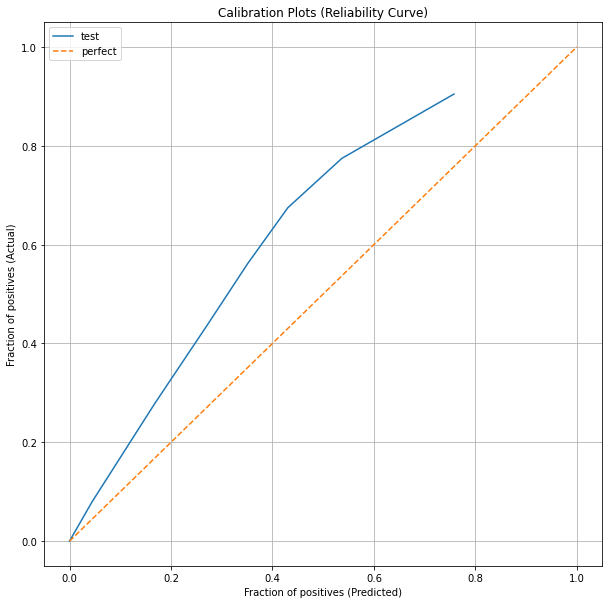

In [35]:
from sklearn.calibration import calibration_curve

plot.figure(figsize=(10,10))
plot_test_truth, plot_test_predictions = calibration_curve(target_test, test_probabilities,strategy='quantile', n_bins=10)
plot.plot(plot_test_predictions, plot_test_truth,label='test')
# Useless to draw train curve : almost identical to test and therefore, invisible
# plot_train_truth, plot_train_predictions = calibration_curve(target_train, train_probabilities,strategy='quantile', n_bins=10)
# plot.plot(plot_train_predictions, plot_train_truth,label='train')

xmin = min(plot_test_predictions.min(), plot_test_truth.min())
xmax = max(plot_test_predictions.max(), plot_test_truth.max())
#plot.plot([xmin,xmax],[xmin,xmax], '--',label='perfect')
plot.plot([0, 1], [0, 1], '--', label='perfect')
plot.xlabel('Fraction of positives (Predicted)')
plot.ylabel('Fraction of positives (Actual)')
plot.ylim([-0.05, 1.05])
plot.legend() # loc='upper left', ncol=2)
plot.title('Calibration Plots (Reliability Curve)')
plot.grid(True)
plot_save('xgboost_calibration_issue')

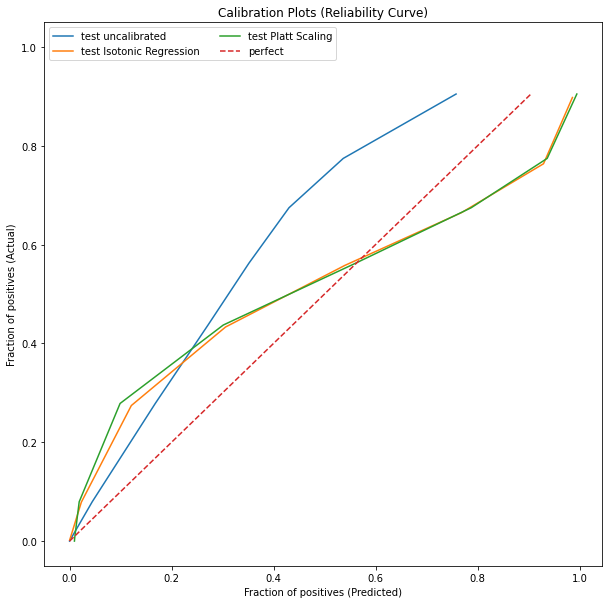

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.calibration import IsotonicRegression


class MyPlattScaling(BaseEstimator):
    def __init__(self, log_odds: bool=True):
        self.log_odds = log_odds
    
    def fit(self, y_prob: numpy.ndarray, y_true: numpy.ndarray):
        self.fit_predict(y_prob, y_true)
        return self

    @staticmethod
    def _convert_to_log_odds(y_prob: numpy.ndarray):
        eps = 1e-12
        y_prob = numpy.clip(y_prob, eps, 1 - eps)
        y_prob = numpy.log(y_prob / (1 - y_prob))
        return y_prob

    def predict(self, y_prob: numpy.ndarray):
        if self.log_odds:
            y_prob = self._convert_to_log_odds(y_prob)

        output = self._transform(y_prob)
        return output

    def _transform(self, y_prob: numpy.ndarray):
        output = y_prob * self.coef_[0] + self.intercept_
        output = 1 / (1 + numpy.exp(-output))
        return output

    def fit_predict(self, y_prob: numpy.ndarray, y_true: numpy.ndarray) -> numpy.ndarray:
        if self.log_odds:
            y_prob = self._convert_to_log_odds(y_prob)

        # the class expects 2d ndarray as input features
        logistic = LogisticRegression(C=1e10, solver='lbfgs')
        logistic.fit(y_prob.reshape(-1, 1), y_true)
        self.coef_ = logistic.coef_[0]
        self.intercept_ = logistic.intercept_

        y_calibrated_prob = self._transform(y_prob)
        return y_calibrated_prob


isotonic = IsotonicRegression(out_of_bounds='clip',
                              y_min=train_probabilities.min(),
                              y_max=train_probabilities.max())
# still valid: learn on train, predict on test
isotonic.fit(train_probabilities,target_train)
isotonic_test_probabilities = isotonic.predict(test_probabilities)
isotonic_challenge_probabilities = isotonic.predict(challenge_probabilities)

platt = MyPlattScaling(log_odds=False)
# still valid: learn on train, predict on test
platt.fit(train_probabilities,target_train)
platt_test_probabilities = platt.predict(test_probabilities)
#platt_train_probabilities = platt.predict(train_probabilities)
platt_challenge_probabilities = platt.predict(challenge_probabilities)

# fig,ax = plot.subplots()
plot.figure(figsize=(10, 10))
plot_test_truth, plot_test_predictions = calibration_curve(target_test, test_probabilities,strategy='quantile', n_bins=10)
plot.plot(plot_test_predictions, plot_test_truth,label='test uncalibrated')

plot_test_truth, plot_test_predictions = calibration_curve(target_test, isotonic_test_probabilities,strategy='quantile', n_bins=10)
plot.plot(plot_test_predictions, plot_test_truth,label='test Isotonic Regression')

plot_test_truth, plot_test_predictions = calibration_curve(target_test, platt_test_probabilities,strategy='quantile', n_bins=10)
plot.plot(plot_test_predictions, plot_test_truth,label='test Platt Scaling')
plot.plot([xmin,xmax],[xmin,xmax], '--',label='perfect')
plot.xlabel('Fraction of positives (Predicted)')
plot.ylabel('Fraction of positives (Actual)')
plot.ylim([-0.05, 1.05])
plot.legend(loc='upper left', ncol=2)
plot.title('Calibration Plots (Reliability Curve)')
plot_save('reliability_curve')

isotonic_test_predictions = numpy.where(isotonic_test_probabilities>0.5,1,0)
isotonic_challenge_predictions = numpy.where(isotonic_challenge_probabilities>0.5,1,0)
print_warning('Now, on test we have %.3f %% of 1 using Isotonic"s recalibrated probabilities' % (100.*isotonic_test_predictions.mean()))
print_warning('And, on challenge we have %.3f %% of 1 using Isotonic"s recalibrated probabilities' % (100.*isotonic_challenge_predictions.mean()))

platt_test_predictions = numpy.where(platt_test_probabilities>0.5,1,0)
platt_challenge_predictions = numpy.where(platt_challenge_probabilities>0.5,1,0)
print_info('Now, we have %.3f %% of 1 using Platt scaling"s recalibrated probabilities' % (100.*platt_test_predictions.mean()))
print_info('And, on challenge we have %.3f %% of 1 using Platt scaling"s recalibrated probabilities' % (100.*platt_challenge_predictions.mean()))

Text(0.5, 1.0, 'Distributions  of probabilities')

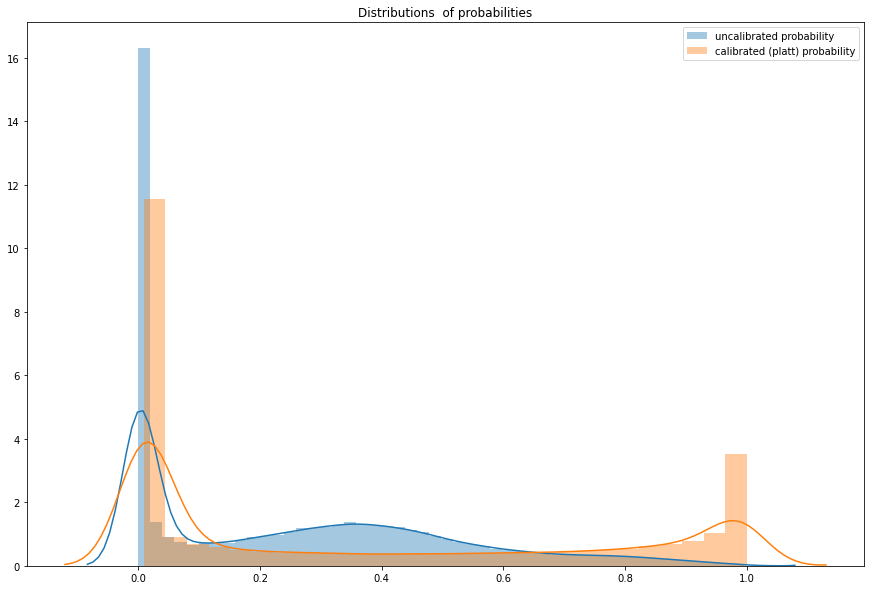

In [37]:
 plot.figure(figsize=(15,10))
 sns.distplot(test_probabilities,label='uncalibrated probability', kde=True)
 sns.distplot(platt_test_probabilities,label='calibrated (platt) probability', kde=True)
 #sns.distplot(isotonic_test_probabilities,label='calibrated (platt) probability', kde=True)
 plot.legend()
 plot.title("Distributions  of probabilities")

In [38]:
print_info('Test has %d rows' %len(target_test))

print_warning('Uncalibrated')
print_warning("logloss % .3f" % metrics.log_loss(target_test,test_probabilities,sample_weight = input_test['weight']))
print(metrics.classification_report(target_test,test_predictions,sample_weight = input_test['weight']))

print_info('Calibrated')
print_info("logloss % .3f" % metrics.log_loss(target_test,platt_test_probabilities,sample_weight = input_test['weight']))
print(metrics.classification_report(target_test,platt_test_predictions,sample_weight = input_test['weight']))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92 66475.35427891841
           1       0.68      0.40      0.51 14213.525233116525

    accuracy                           0.86 80688.87951203494
   macro avg       0.78      0.68      0.71 80688.87951203494
weighted avg       0.85      0.86      0.85 80688.87951203494



              precision    recall  f1-score   support

           0       0.94      0.85      0.89 66475.35427891841
           1       0.51      0.75      0.61 14213.525233116525

    accuracy                           0.83 80688.87951203494
   macro avg       0.73      0.80      0.75 80688.87951203494
weighted avg       0.87      0.83      0.84 80688.87951203494



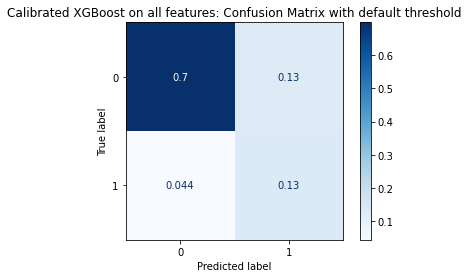

In [39]:
print_info('Calibrated with Plott Scaling')
#calibrated_confusion_matrix = confusion_matrix(target_test,platt_test_predictions,sample_weight=input_test['weight'])
#ConfusionMatrixDisplay(calibrated_confusion_matrix).plot(cmap=plot.cm.Blues,values_format=".0f")
calibrated_confusion_matrix = confusion_matrix(target_test,platt_test_predictions,sample_weight=input_test['weight'],normalize="all")
ConfusionMatrixDisplay(calibrated_confusion_matrix).plot(cmap=plot.cm.Blues)
plot.title('Calibrated XGBoost on all features: Confusion Matrix with default threshold')
plot_save('calibrated_xgboost_all_features_confusion_matrix2')

We have a model. Let's dig:

* what are the important features
* can we get rid of some features (hopefully the heavy ones)


BE CAREFUL : except univariables, all that does not work ...

is_duplicate                                                              1.000000
all_nb_common_words/(all_nb_words_question1+all_nb_words_question2)       0.456488
nltk_nb_common_words/(nltk_nb_words_question1+nltk_nb_words_question2)    0.456047
all_nb_common_words/all_nb_words_question1                                0.447348
nltk_nb_common_words/nltk_nb_words_question1                              0.445528
                                                                            ...   
nb_entities_common_WORK_OF_ART                                            0.001799
ratio_nb_entities_common_PRODUCT                                          0.000879
proba_vehicles_question1                                                  0.000741
nb_entities_common_PRODUCT                                                0.000240
nb_entities_WORK_OF_ART_question2                                         0.000045
Name: is_duplicate, Length: 104, dtype: float64


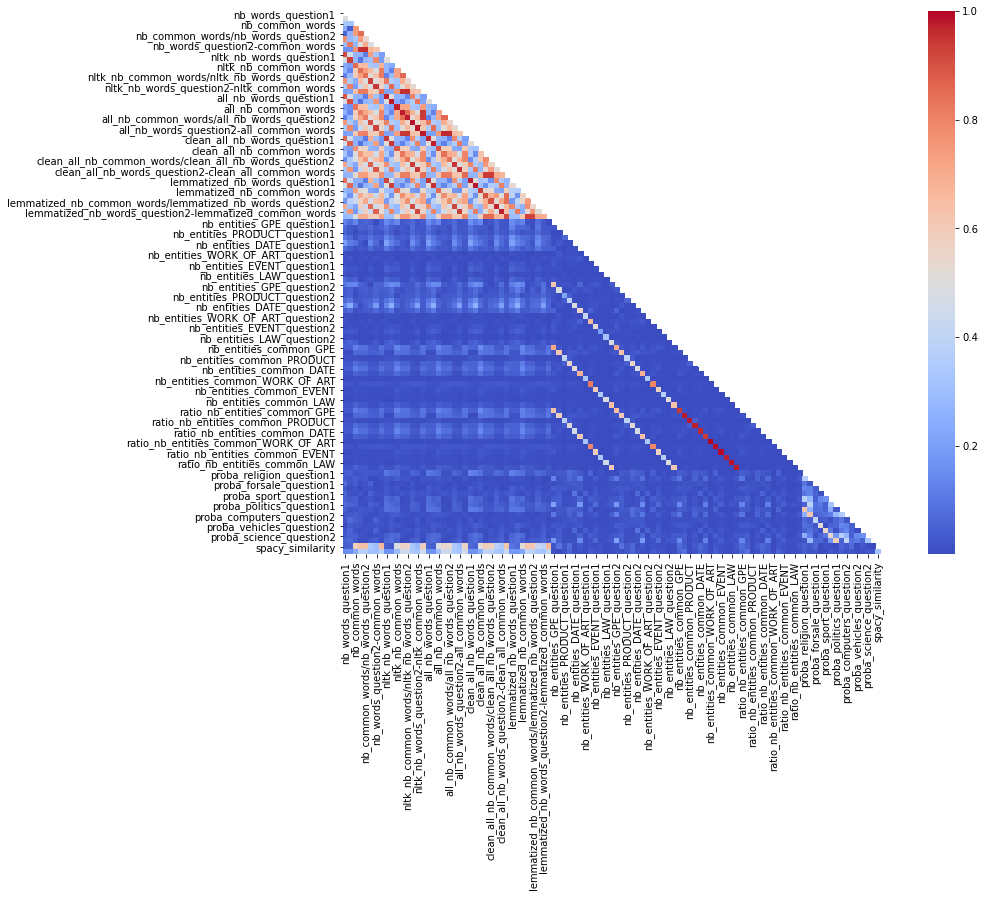

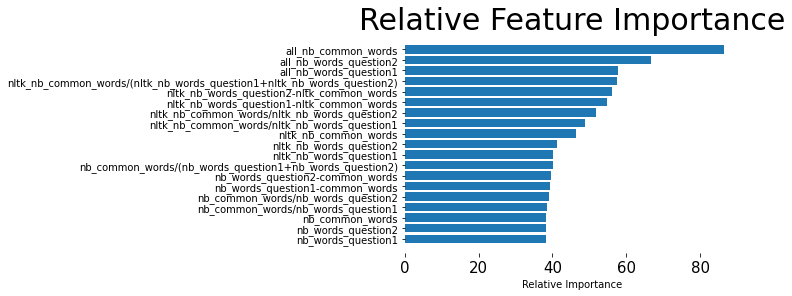

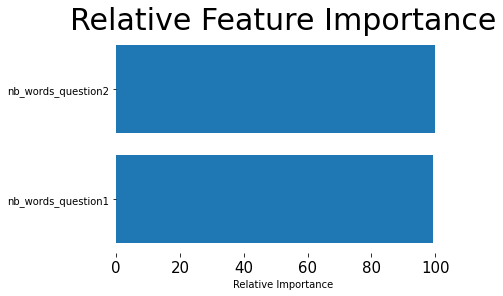

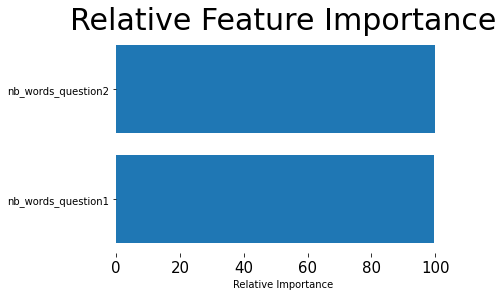

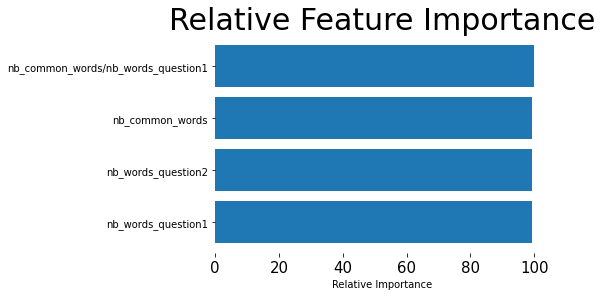

ValueError: Negative values in data passed to MultinomialNB (input X)

In [40]:
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest,f_classif,RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

def graph_relative_feature_importance(features_importances,columns):
    # Make importances relative to max importance.
    features_importances = 100.0 * (features_importances / features_importances.max())
    sorted_idx = numpy.argsort(features_importances)
    sorted_idx = sorted_idx[-20:-1:1]
    pos = numpy.arange(sorted_idx.shape[0]) + 0.5
    plot.barh(pos, features_importances[sorted_idx], align='center')
    plot.yticks(pos, columns)
    plot.xlabel('Relative Importance')
    plot.title('Relative Feature Importance', fontsize=30)
    plot.tick_params(axis='x', which='major', labelsize=15)
    sns.despine(left=True, bottom=True)
    plot.show()

def graph_feature_importance(features_importances,columns):
    # Make importances relative to max importance.
    sorted_idx = numpy.argsort(features_importances)
    sorted_idx = sorted_idx[-20:]
    pos = numpy.arange(sorted_idx.shape[0]) + 0.5
    plot.barh(pos, features_importances[sorted_idx], align='center')
    plot.yticks(pos, columns)
    plot.xlabel('Importance')
    plot.title('Feature Importance', fontsize=30)
    plot.tick_params(axis='x', which='major', labelsize=15)
    #sns.despine(left=True, bottom=True)
    plot.show()

def independant_features_analysis(name_data,input_df,target_df):
    train_df = input_df[all_numeric_columns(input_df)]
    target_df = target_df
    small = int(len(target_df)*0.05)
    small_train = train_df.sample(small,random_state=42)
    small_target = target_df.sample(small,random_state=42)
    small_weights = input_df[WEIGHT].sample(small,random_state=42)

    # be careful all_numeric will include also the target soon
    all_numeric = all_numeric_columns(input_df)
    print_section('Minimal analysis of numeric features of %s' % name_data)
    print_info('Nb features: %d' % len(all_numeric))
    print_info(str(all_numeric))
    print_warning('Is there any null value ? %s' % input_df.isnull().any().any())

    compute_variances = feature_selection.VarianceThreshold()
    all_numeric.append('is_duplicate')
    variances = compute_variances.fit_transform(input_df[all_numeric])
    print_warning('Is there any low variance feature ? %s' % str(variances.shape[1]!=len(all_numeric)))
    print_info('Here are the correlations to the target "is_duplicate"')
    correlation_matrix = input_df[all_numeric].corr().abs()
    print(correlation_matrix['is_duplicate'].nlargest(len(all_numeric)))

    correlation_matrix_without_is_duplicate = correlation_matrix['is_duplicate'][correlation_matrix['is_duplicate']<1]
    highest_correlated_feature = correlation_matrix_without_is_duplicate.nlargest(1).index[0]
    highest_correlation = correlation_matrix_without_is_duplicate.nlargest(1)[0]
    if highest_correlation >0.2:
        if highest_correlation < 0.5:
            print_warning('%s is the most correlated with target but %f is quite weak' % (highest_correlated_feature,highest_correlation))
        else:
            print_info('%s is the most correlated with target but %f is very weak' % (highest_correlated_feature,highest_correlation))
    else:
        print_alert('%s is the most correlated with target and %f is quite big' % (highest_correlated_feature,highest_correlation))
    plot.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix,annot=False,cbar=True,square=True,cmap='coolwarm',mask = numpy.triu(correlation_matrix))
    plot.show()

    # we keep only numeric features and remove is_duplicate
    all_numeric = all_numeric_columns(input_df)

    print_section('Here are the features that would be selected with a simple univariate analysis')
    start = time.time()
    #for r in tqdm(range(1,len(all_numeric))):
    for r in [103]:
        k_best = SelectKBest(score_func=f_classif,k=r)
        fit = k_best.fit(small_train,small_target)
        best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
        print_info('Nb features to keep %d:%s' %(r,best_columns))
        
        # Can we graph relative importances
        if r>1:
            # transform train set so we can compute importances
            univariate_features = fit.transform(small_train)
            rfc = RandomForestClassifier(n_estimators=100)
            rfc_scores = cross_val_score(rfc, univariate_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
            features_importance = rfc.fit(univariate_features, small_target).feature_importances_
            graph_relative_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)
    
    

    print_info('Try to keep x \% of variance with a PCA')
    print_alert('bug ?')
    start = time.time()
    for r in tqdm([.8,.9,.95]):
        acp = PCA(r)
        principal_components = acp.fit_transform(small_train)
        principal_df = pandas.DataFrame(principal_components).sample(small,random_state=42)
        rfc = RandomForestClassifier(n_estimators=100)
        rfc_scores = cross_val_score(rfc, principal_df, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
        features_importance = rfc.fit(principal_df, small_target).feature_importances_
        print_info('%% of variance %f:%s' %(r,'aie'))
        graph_relative_feature_importance(features_importance,small_train.columns)
    print_done('Done',top=start)

    print_section('Here are the features that would be selected with a recursive feature elimination')
    start = time.time()
    print_alert('Doomed to fail : RFE does not support to transmit ,sample_weight=small_weights')
    print_alert('ix is waiting since 2016 ?')
    for r in tqdm(range(1,len(all_numeric))):
        mnb = MultinomialNB()
        recursive_best= feature_selection.RFE(mnb, n_features_to_select=r)
        fit = recursive_best.fit(small_train,small_target)
        best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
        print_info('Nb features to keep %d:%s' %(r,best_columns))
        
        # Can we graph relative importances
        if r>1:
            # transform train set so we can compute importances
            recursive_features = fit.transform(small_train)
            rfc = RandomForestClassifier(n_estimators=100)
            rfc_scores = cross_val_score(rfc, recursive_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
            features_importance = rfc.fit(recursive_features, small_target).feature_importances_
            graph_relative_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)

independant_features_analysis('train',train_dataframe,train_dataframe['is_duplicate'])

<Figure size 1080x720 with 0 Axes>

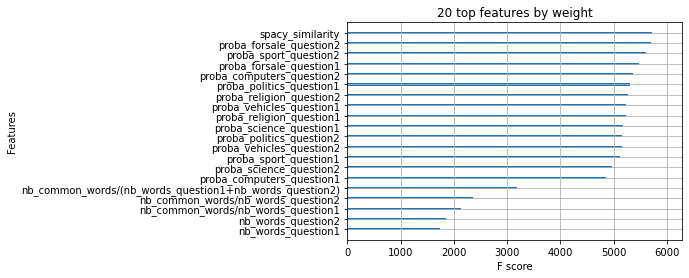

<Figure size 1080x720 with 0 Axes>

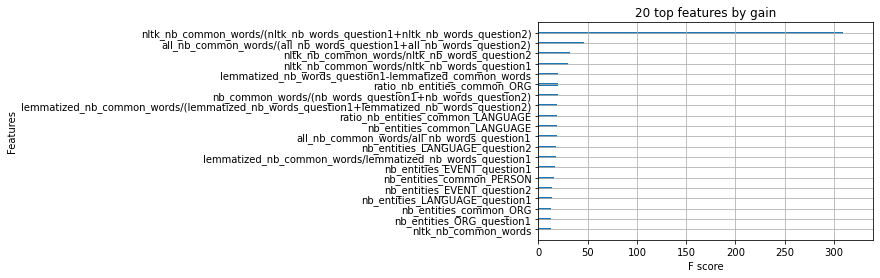

In [41]:
from xgboost import plot_tree
#ax, height, xlim, ylim, title, xlabel, ylabel, fmap, importance_type, max_num_features, grid, show_values, **kwargs
def show_topn_features(model,importance_type,top=10):
    plot.figure(figsize=(15,10))
    fig,ax = plot.subplots()
    ax = xgboost.plot_importance(model,max_num_features=top,ax = ax ,title='%d top features by %s' % (top,importance_type),grid=True,show_values=False,importance_type=importance_type)
    yticklabels = ax.get_yticklabels()[::-1]
    if top == -1:
        top = len(yticklabels)
    else:
        top = min(top, len(yticklabels))
        print_section("importance by %s" % importance_type)
    features = [yticklabels[i].get_text() for i in range(top)]
    print_info(str(features))
    return features
        
#plot.figure(figsize=(30, 20))
#xgboost.plot_importance(model,max_num_features=18)#
#plot.show()

top_by_weight = show_topn_features(model,importance_type='weight',top=20)
top_by_gain = show_topn_features(model,importance_type='gain',top=20)
features_to_keep_39 = list(set.union(set(top_by_weight),set(top_by_gain)))
print_section('Top %d features to keep' % len(features_to_keep_39))
print_info(str(features_to_keep_39))


#  I don't understand what this is 
# show_topn_features(model,importance_type='cover',top=20)

We have selected 39 variables that looked like important for xgboost
What is happening if we recompute a model with only these variables ?

**My decision** I keep the parameters from optimisation on all features

In [ ]:

params= {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'colsample_bytree': 0.7000000000000001,
    'eta': 0.05,
    'gamma': 0.8500000000000001,
    'max_depth': 11,
    'min_child_weight': 3.0,
    'n_estimators': 868.0,
    'subsample': 0.9500000000000001}
    
    
xgboost_39 = study_models_one_more_field_at_a_time(
    '39 features all_preprocess optim',
    '39_features_all_preprocess_optim',
    features_to_keep_39,
    train_dataframe,
    challenge_dataframe,
    explore = False,
    show = False)

In [42]:
all_submissions = load_kaggle_submissions()
get_last_submissions(all_submissions,10)

EmptyDataError: No columns to parse from file

In [ ]:
top_by_weight = show_topn_features(model,importance_type='weight',top=10)
top_by_gain = show_topn_features(model,importance_type='gain',top=10)
features_to_keep_20 = list(set.union(set(top_by_weight),set(top_by_gain)))
print_section('Top %d features to keep' % len(features_to_keep_20))
print_info(str(features_to_keep_20))

In [ ]:
params= {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'colsample_bytree': 0.7000000000000001,
    'eta': 0.05,
    'gamma': 0.8500000000000001,
    'max_depth': 11,
    'min_child_weight': 3.0,
    'n_estimators': 868.0,
    'subsample': 0.9500000000000001}
    
    
xgboost_20 = study_models_one_more_field_at_a_time(
    '20 features all_preprocess optim',
    '20_features_all_preprocess_optim',
    features_to_keep_20,
    train_dataframe,
    challenge_dataframe,
    explore = False,
    show = False)

In [ ]:
all_submissions = load_kaggle_submissions()
get_last_submissions(all_submissions,10)

Strategy : semantic features only


In [ ]:
ALL_SEMANTIC_FEATURES=[c for c in all_numeric_columns(train_dataframe) if 'entities' in c or 'proba' in c or 'sim' in c]
print(ALL_SEMANTIC_FEATURES)

In [ ]:
xgboost_semantic = study_models_one_more_field_at_a_time(
    'semantic features  optim',
    'semantic_features_optim',
    ALL_SEMANTIC_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore = False,
    show = False)

In [ ]:
all_submissions = load_kaggle_submissions()
get_last_submissions(all_submissions,10)

In [ ]:
ALL_EASY_FEATURES=[c for c in all_numeric_columns(train_dataframe) if 'entities' not in c and 'entities' not in c and 'sim' not in c and 'lemm' not in c]
print(ALL_EASY_FEATURES)

In [ ]:
xgboost_easy = study_models_one_more_field_at_a_time(
    'easy features  optim',
    'easy_features_optim',
    ALL_EASY_FEATURES,
    train_dataframe,
    challenge_dataframe,
    explore = False,
    show = False)